This notebook includes all the code in order to extract features and classify them

In [5]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from matplotlib import pyplot, gridspec
import neurokit2 as nk2
import matplotlib.pyplot as plt
import statistics
import scipy as sci
import pickle
import os
import heartpy as hp
import GazeParser
from sklearn import preprocessing, model_selection
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

Starting with importing the raw ecg & gsr data into dataframes, it also excludes the trials with technical difficulty

In [18]:
data = []
# Getting all the files in the data directory
files = os.listdir("./raw_data/ecg-gsr-labels/")
removed = ['101_PreProcessed_GSR_ECG.dat', '102_PreProcessed_GSR_ECG.dat', '103_PreProcessed_GSR_ECG.dat', '115_PreProcessed_GSR_ECG.dat', '118_PreProcessed_GSR_ECG.dat', '121_PreProcessed_GSR_ECG.dat', '119_PreProcessed_GSR_ECG.dat', '130_PreProcessed_GSR_ECG.dat']

for item in removed:
    files.remove(item)

for i in range(len(files)):
    infile = open("./raw_data/ecg-gsr-labels/" + files[i],'rb')
    data.append(pickle.load(infile))
    infile.close()

# Extracting all data (labels, ecg and gsr data) into seperate arrays.

completeLabels = []
completeEcg = []
completeGsr = []

# Iterate over all files
for i in range(len(data)):
    del data[i]['Data'][0]
    del data[i]['Labels'][0]
    features = data[i]['Data']
    labels = data[i]['Labels']
    #Iterate over all examples in file
    for x in range(len(labels)):
        completeLabels.append(labels[x])
        completeEcg.append(features[x][:][:,1])
        completeGsr.append(features[x][:][:,0])

pd.DataFrame.from_dict(completeLabels).to_csv('processed_data/labels.csv')
labelslen = len(completeLabels)
ecglen = len(completeEcg)
gsrlen = len(completeGsr)
print(f"Completed:{labelslen} lables, {ecglen} ECG inputs, {gsrlen} GSR inputs")

Completed:312 lables, 312 ECG inputs, 312 GSR inputs


Now we have the ecg, gsr and labels we can extract the eye tracking data

In [19]:
data = []
# Getting all the files in the data directory
files = os.listdir("./raw_data/eye-track/")

completeEyeLabels = []
completeData = []

for i in range(len(files)):
    infile = open("./raw_data/eye-track/" + files[i],'rb')
    data.append(pickle.load(infile))
    infile.close()
for i in range(len(data)):
    eyefeatures = data[i]['Data']
    eyelabels = data[i]['Labels']
    #Iterate over all examples in file
    for x in range(len(eyelabels)):
        completeEyeLabels.append(eyelabels[x])
        completeData.append(eyefeatures[x])

Now were extracting the ECG and GSR Features manually and using Neurokit

In [20]:
def nkExtractECG(signal,samplerate):
    cleaned = nk2.ecg_clean(signal,sampling_rate=samplerate)
    processed, info = nk2.ecg_process(cleaned,sampling_rate=samplerate)
    compECG = nk2.ecg_intervalrelated(processed)
    return compECG

def extractECGfeatures(samplerate):
    print("started ECG extraction")
    # Preprocess the data (filter, find peaks, etc.)
    completeFrame = pd.DataFrame([])

    for index, ecg in enumerate(completeEcg): #loops through all 312 data items from the extracted items
        tems = nkExtractECG(ecg,samplerate)
        #temp = pd.DataFrame([tems])
        completeFrame = pd.concat([completeFrame,tems])
    #completeFrame.drop(completeFrame.columns[0], axis=1,inplace=True) #removes first empty column
    completeFrame.to_csv('processed_data/ecgNK.csv')
    print("Completed ECG extraction")


def extractGSR(signal,samplerate):
    signal = hp.filter_signal(signal, 0.1, 1000)
    processed_gsr,infos = nk2.eda_process(signal,sampling_rate=samplerate) #processes the GSR, currently only doing one item to make sure it works properly
    #plot = nk2.eda_plot(processed_gsr[:30000], sampling_rate=1000) #plots the signal on a graph

    gsr_dict = nk2.eda_findpeaks(processed_gsr)#finding peaks, time of the peaks and magnitude of peaks

    numpeakssci = len(sci.signal.find_peaks(signal)[0])/len(signal)
    numvalleys = len(sci.signal.find_peaks(signal*(-1))[0])/len(signal)

    peaktime = gsr_dict['SCR_Peaks'] #time of peaks
    numpeaks = len(peaktime)/len(signal) #number of peaks
    timebetween = []
    lastPeak = 0
    for peaks in peaktime: # going through all the peaks in the exrtacted data
        if lastPeak != 0:
            timebetween.append(peaks-lastPeak) #finding the time between the peaks
        else:
            lastPeak = peaks

    if len(timebetween) >= 1:
        meantbpeaks = statistics.mean(timebetween) #mean time between peaks
        mediantbpeaks = statistics.median(timebetween) # median time between peaks
        meanheightpeaks = statistics.mean(gsr_dict['SCR_Height']) #mean magnitide of peaks
        medianheightpeaks = statistics.median(gsr_dict['SCR_Height']) #median magnitide of peaks
        varheightpeaks = statistics.variance(gsr_dict['SCR_Height']) #variance magnitide of peaks
    elif len(gsr_dict['SCR_Height']) >= 1:
        meantbpeaks = 0 #mean time between peaks
        mediantbpeaks = 0 # median time between peaks
        meanheightpeaks = statistics.mean(gsr_dict['SCR_Height']) #mean magnitide of peaks
        medianheightpeaks = statistics.median(gsr_dict['SCR_Height']) #median magnitide of peaks
        if len(gsr_dict['SCR_Height']) >= 2:
            varheightpeaks = statistics.variance(gsr_dict['SCR_Height']) #variance magnitide of peaks
        else:
            varheightpeaks = 0
    else:
        meantbpeaks = 0 #mean time between peaks
        mediantbpeaks = 0 # median time between peaks
        meanheightpeaks = 0 #mean magnitide of peaks
        medianheightpeaks = 0 #median magnitide of peaks
        varheightpeaks = 0 #variance magnitide of peaks

    maxGSR = max(signal)
    minGSR = min(signal)
    meanGSR = statistics.mean(signal)
    peakratio = 0
    if numpeaks>0: peakratio = numpeaks/len(signal)
    valleyratio =0
    if numvalleys>0: valleyratio = numvalleys/len(signal)

    d = {'max GSR': maxGSR,
         'min GSR': minGSR,
         'mean GSR': meanGSR,
         'number of peaks':numpeaks,
         'number of peaks SCIPY': numpeakssci,
         'number of valleys': numvalleys,
         'mean time between peaks':meantbpeaks,
         'median time between peaks':mediantbpeaks,
         'mean height of peaks': meanheightpeaks,
         'median height of peaks': medianheightpeaks,
         'variance height of peaks': varheightpeaks,
         'ratio of peaks': peakratio,
         'ratio of valleys': valleyratio}
    #adding to dataframe to be stored as csv later
    return pd.DataFrame([d])

def extractGSRfeatures(samplerate):
    print("started GSR extraction")
     # Preprocess the data (filter, find peaks, etc.)
    completeFrame = pd.DataFrame([])

    for index, gsr in enumerate(completeGsr): #loops through all 398 data items from the extracted items

        temp = extractGSR(gsr,samplerate)
        completeFrame = pd.concat([completeFrame,temp])
    #completeFrame.drop(completeFrame.columns[0], axis=1,inplace=True) #removes first empty column
    completeFrame.to_csv('processed_data/gsrNK.csv')
    print("Completed GSR extraction")





samplerate = 1000
#extractGSRfeatures(samplerate)
#extractECGfeatures(samplerate) #uncomment to run extraction

Now I am forming the datasets to be used in the machine learning process

In [21]:
ecg = pd.read_csv('./processed_data/ecgNK.csv')
gsr = pd.read_csv('./processed_data/gsrNK.csv')
labels = pd.read_csv('./given_data/labels.csv')
eyes = pd.read_csv('./given_data/eye.csv')

#removing unnecessary columns from data and concatenating into one dataset
ecg.drop(['HRV_ULF','HRV_VLF'],axis=1, inplace=True)
min_max_scaler = preprocessing.MinMaxScaler()

#scaling the ecg and gsr data using minmax scaler
ecgLab = ecg.columns.values.tolist()
ecgScale = min_max_scaler.fit_transform(ecg)
ecg = pd.DataFrame.from_dict(ecgScale)
ecg.columns= ecgLab

gsrLab = list(gsr.columns.values)
gsrScale = min_max_scaler.fit_transform(gsr)
gsr = pd.DataFrame.from_dict(gsrScale)
gsr.columns = gsrLab

ds1 = pd.concat([ecg,gsr,eyes,labels], axis=1, join='inner').sort_index()
ds1.to_csv('processed_data/completeData.csv', index=False)

ds1 = pd.concat([ecg,gsr,labels], axis=1, join='inner').sort_index()
ds1.to_csv('processed_data/ecggsr.csv', index=False)

ds3 = pd.concat([ecg,gsr,labels], axis=1, join='inner').sort_index()
ds3.loc[ds3["labels"] == 1, "labels"] = 0
ds3.loc[ds3["labels"] == 2, "labels"] = 1
ds3.loc[ds3["labels"] == 3, "labels"] = 1
ds3.to_csv("./processed_data/completeDatabinarynoeye.csv")

Starting machine learning

c:\users\tomje\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tomje\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\tomje\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

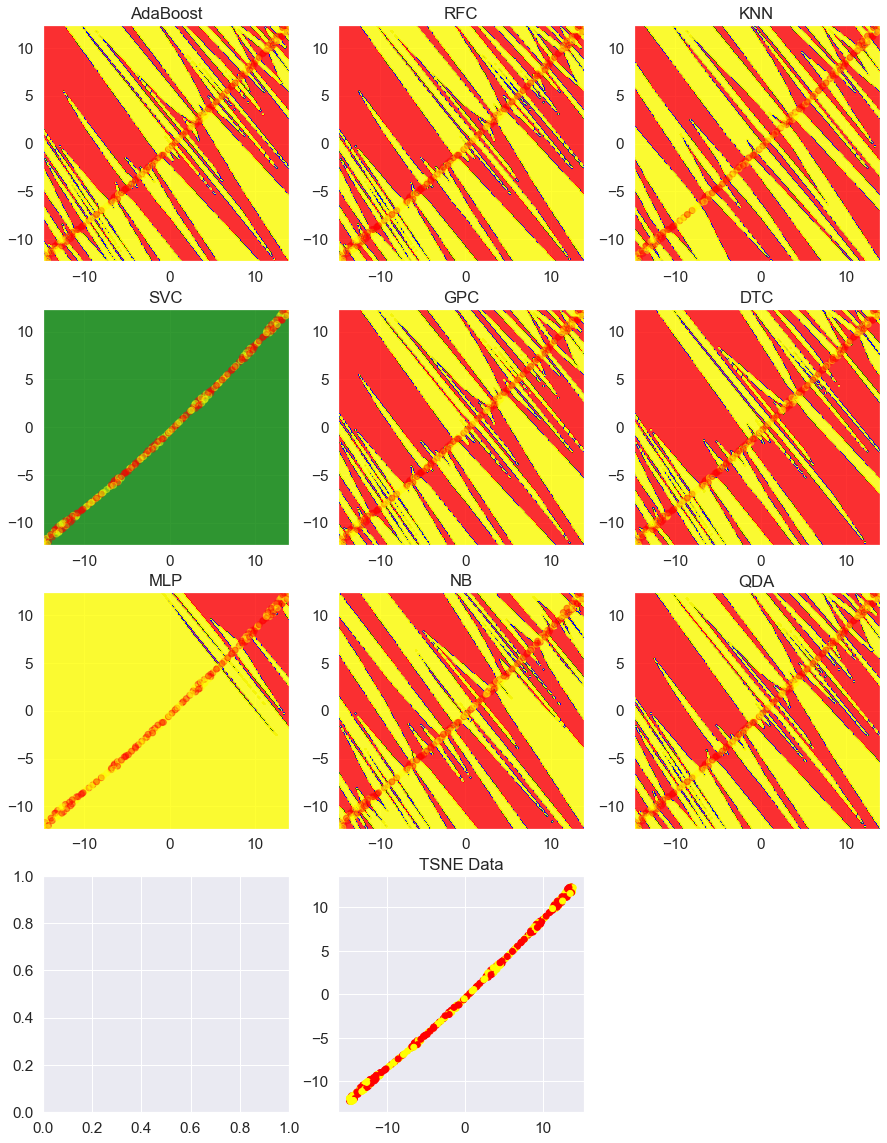

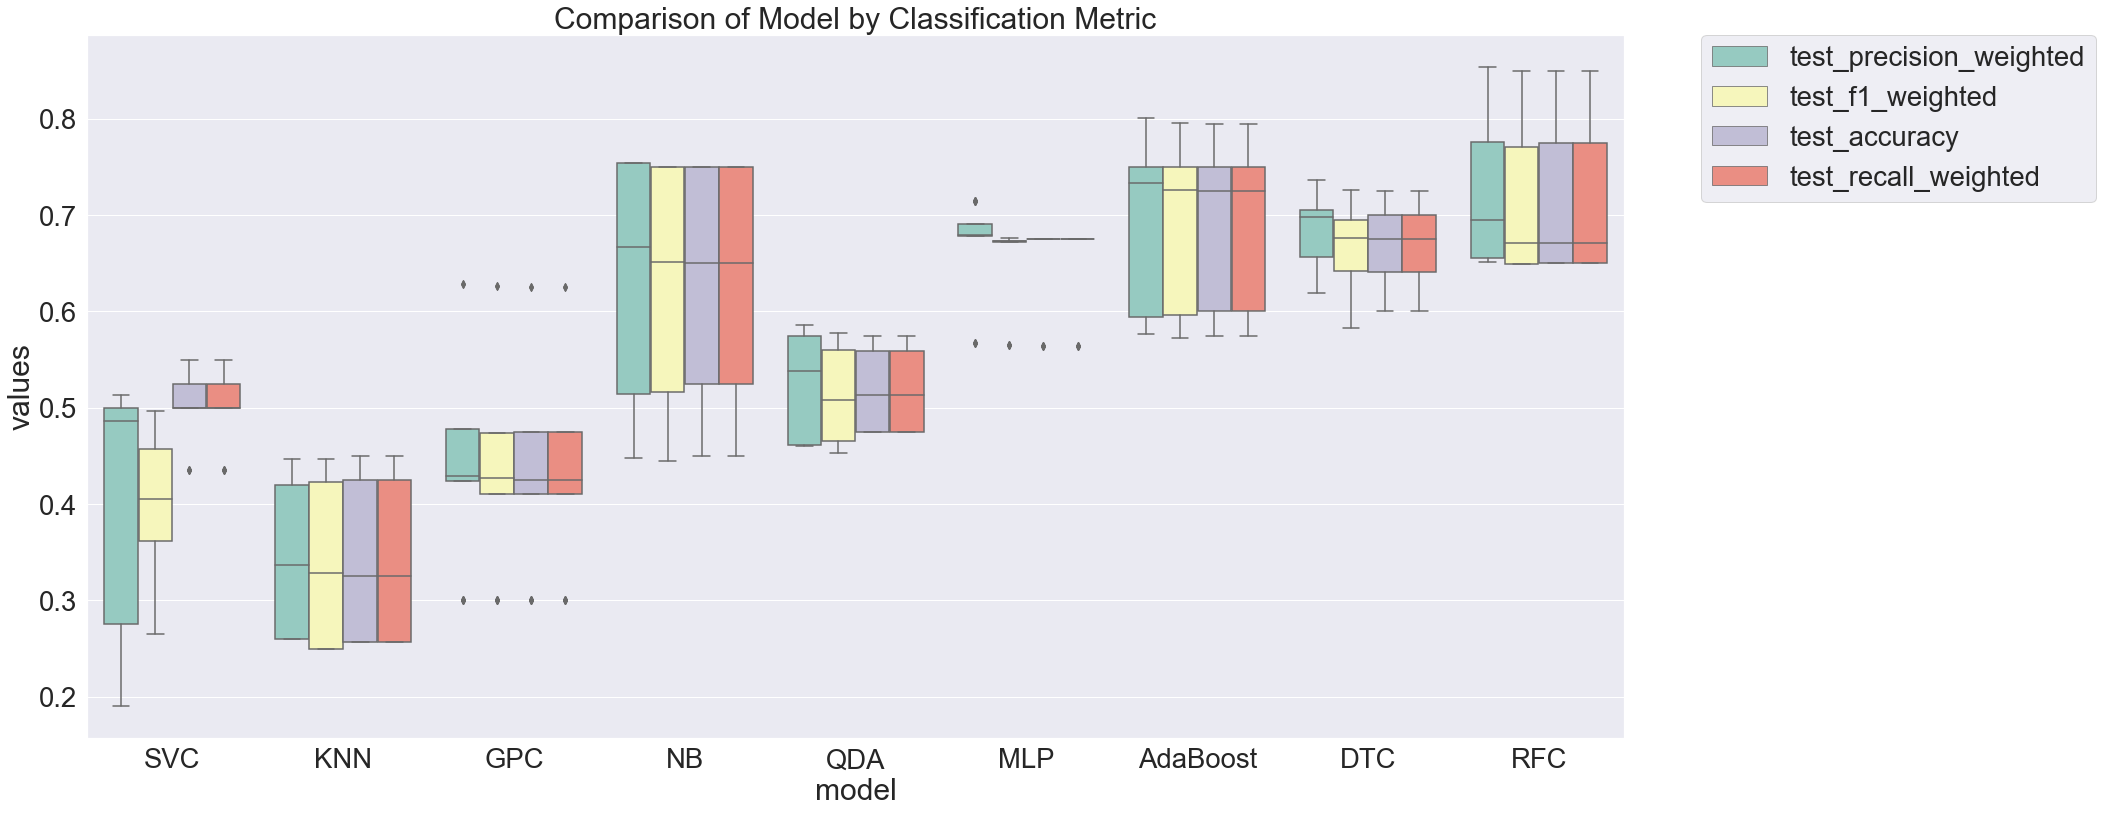

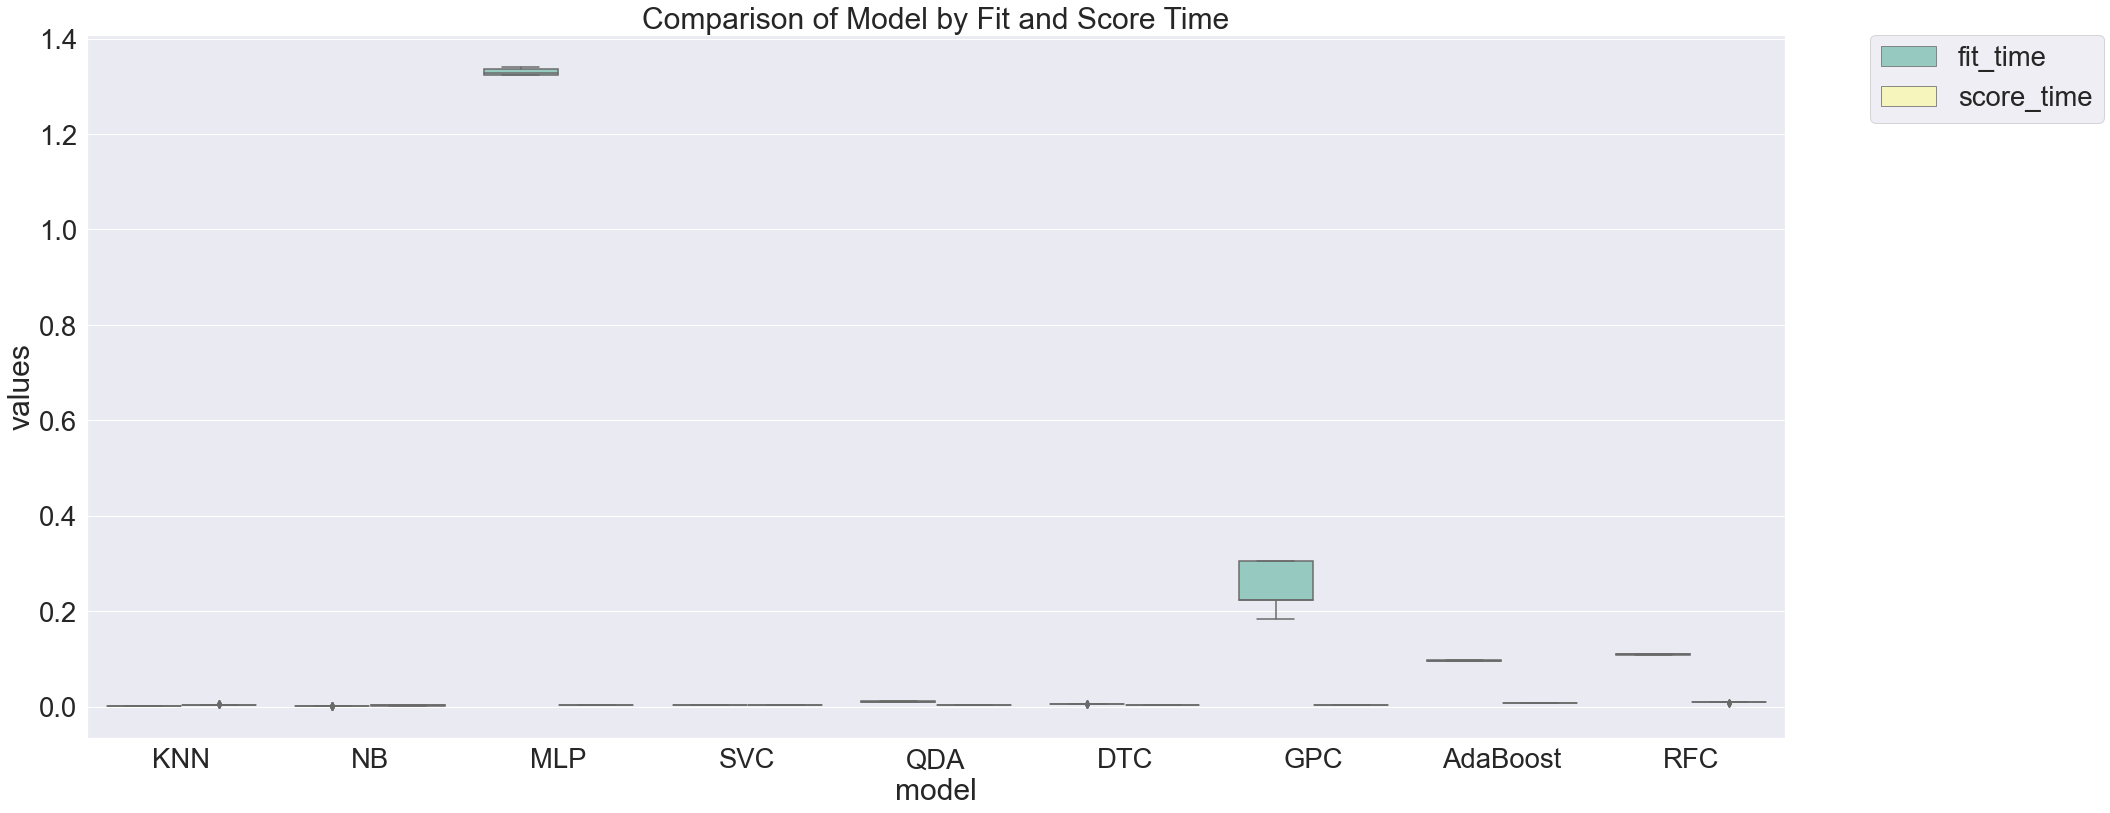

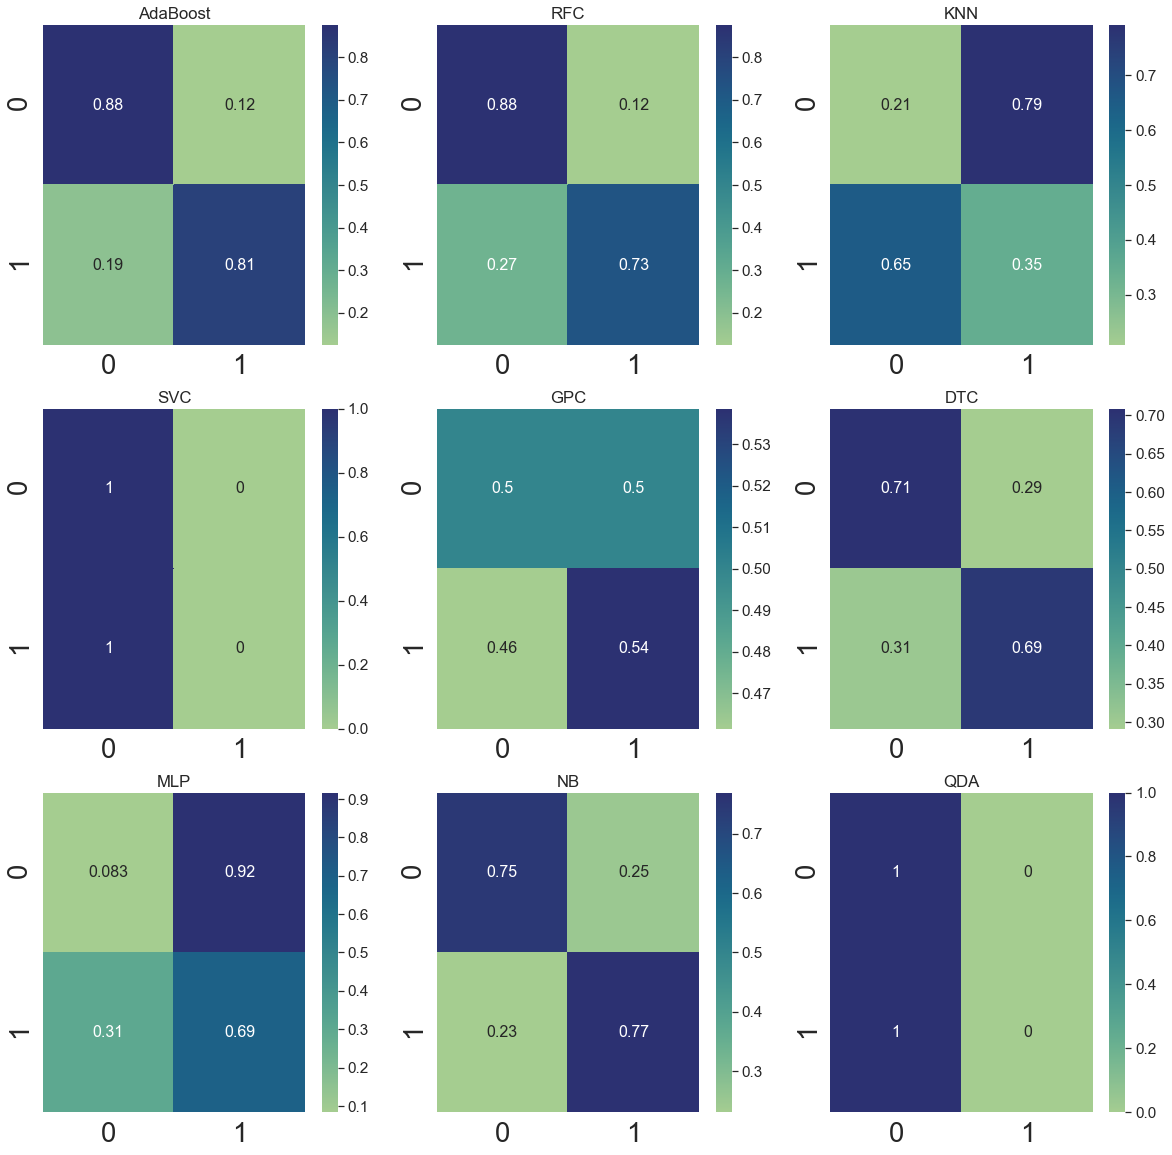

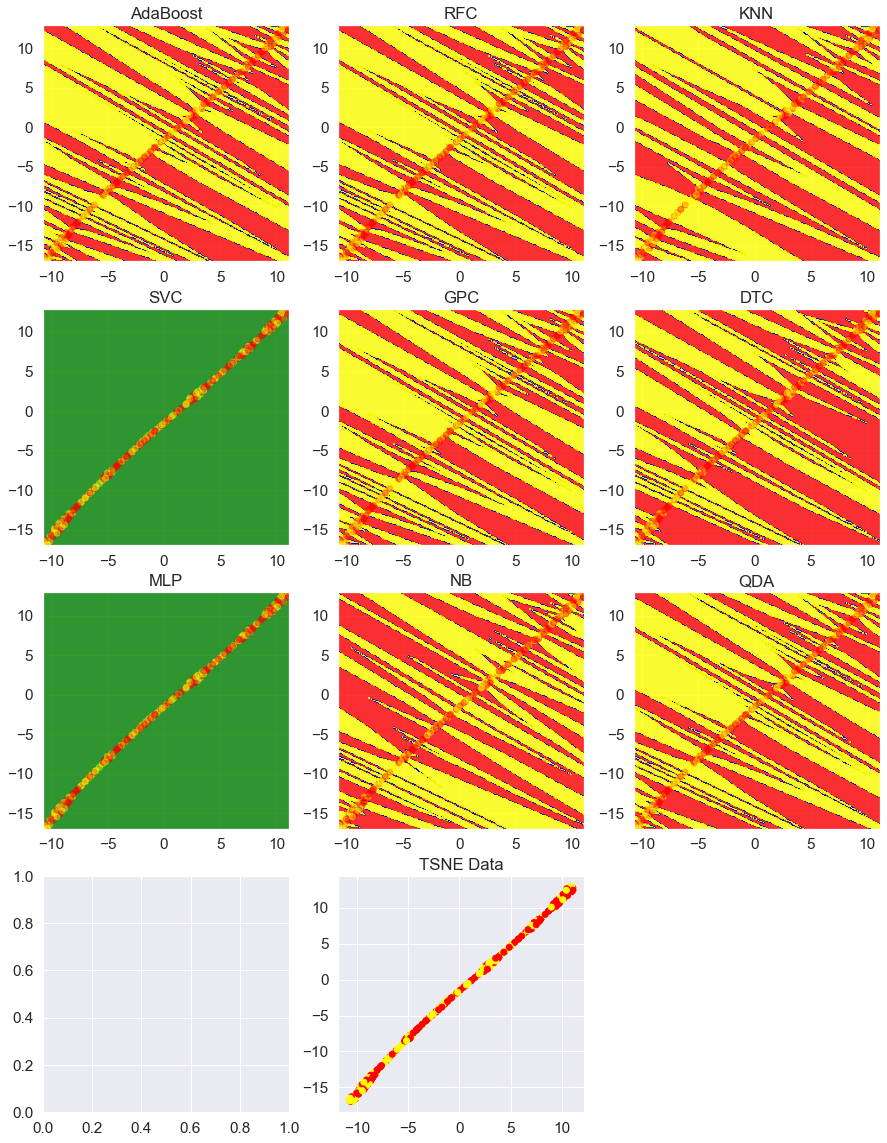

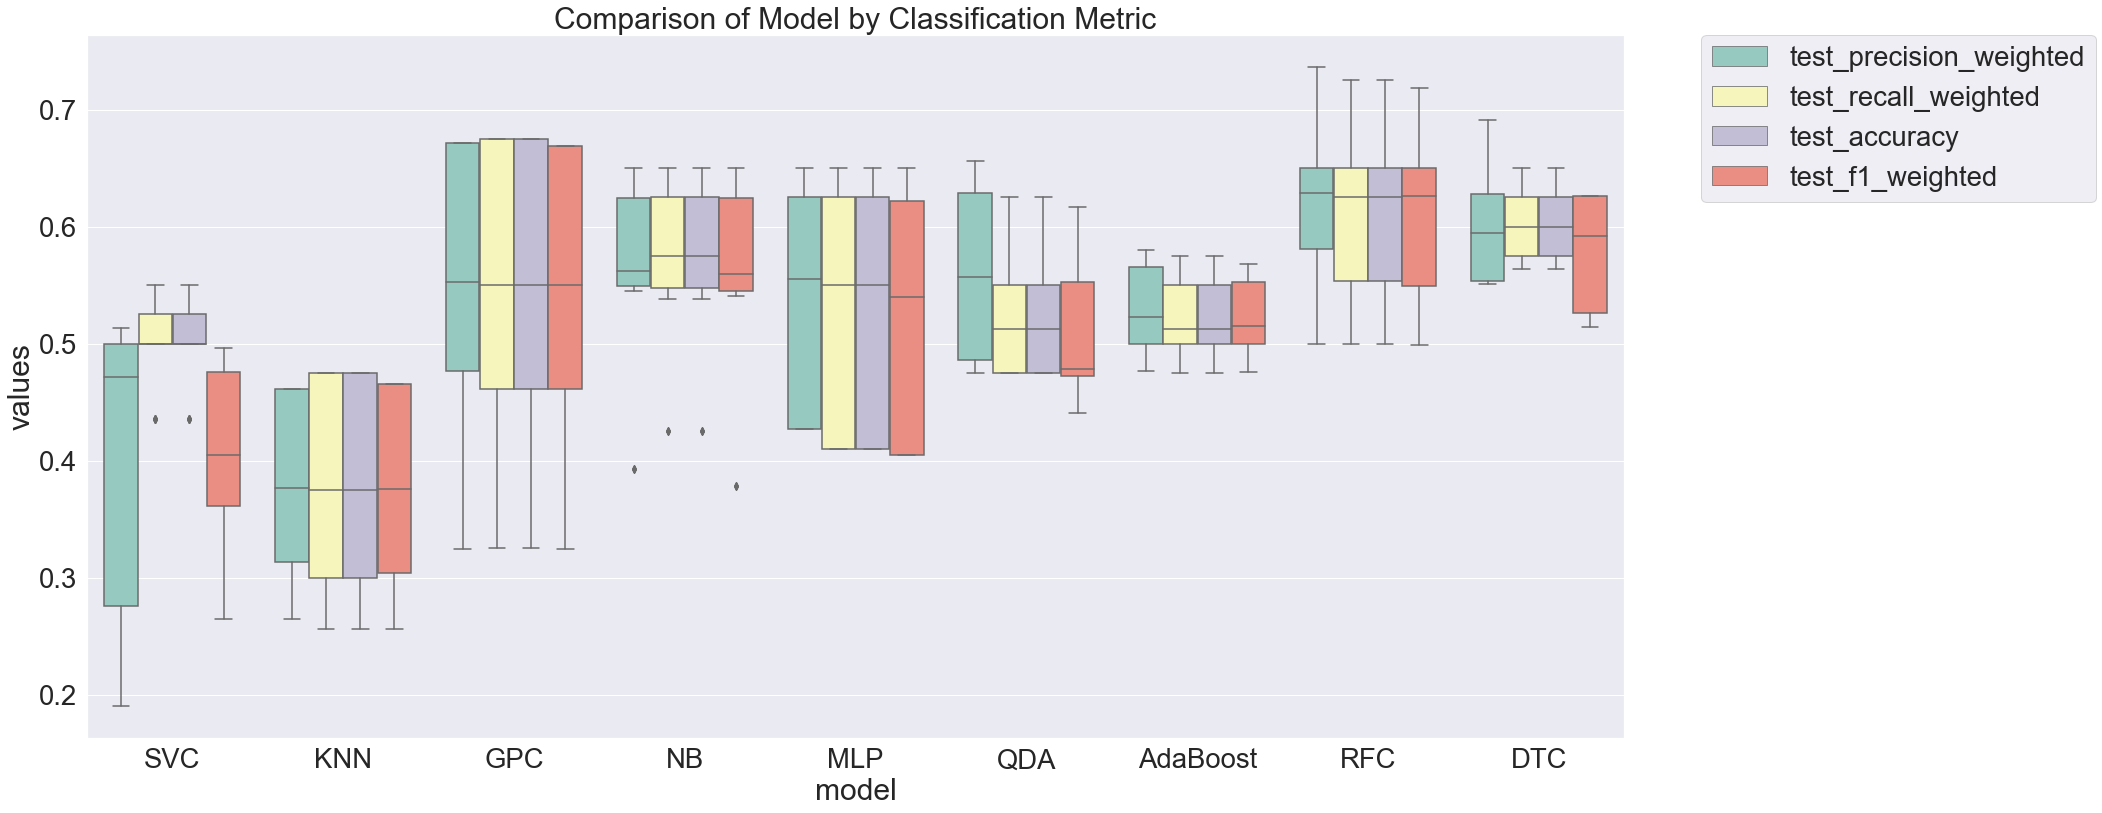

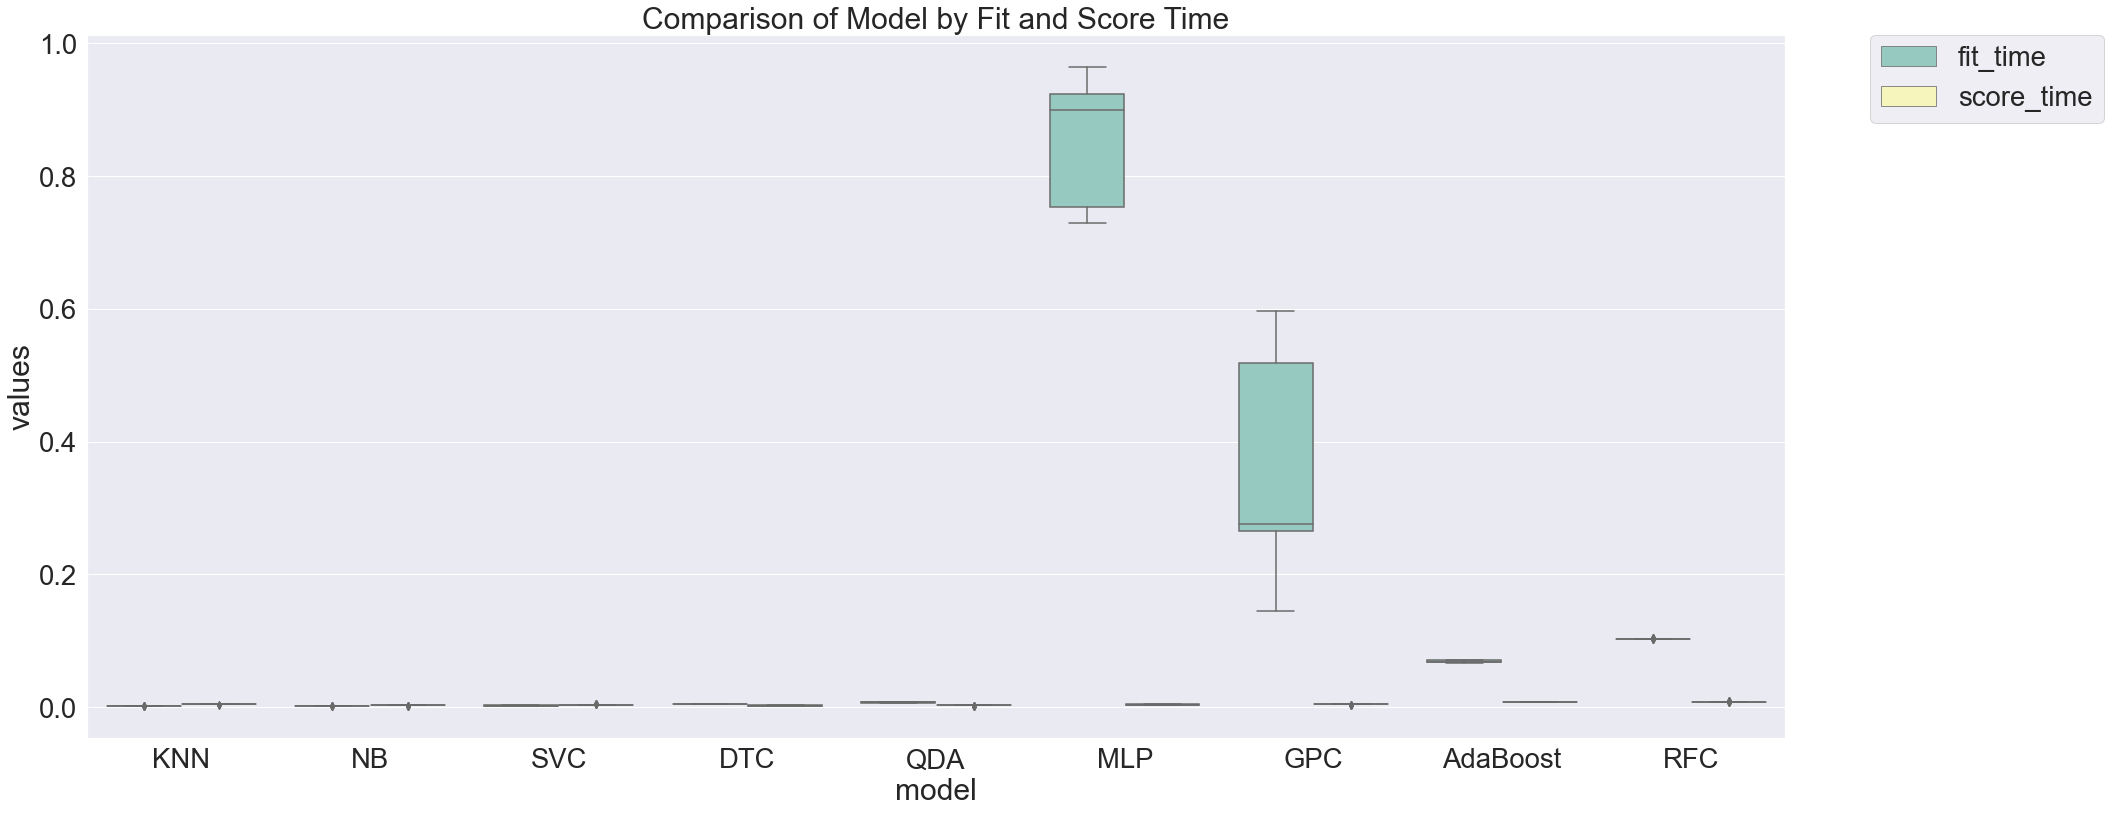

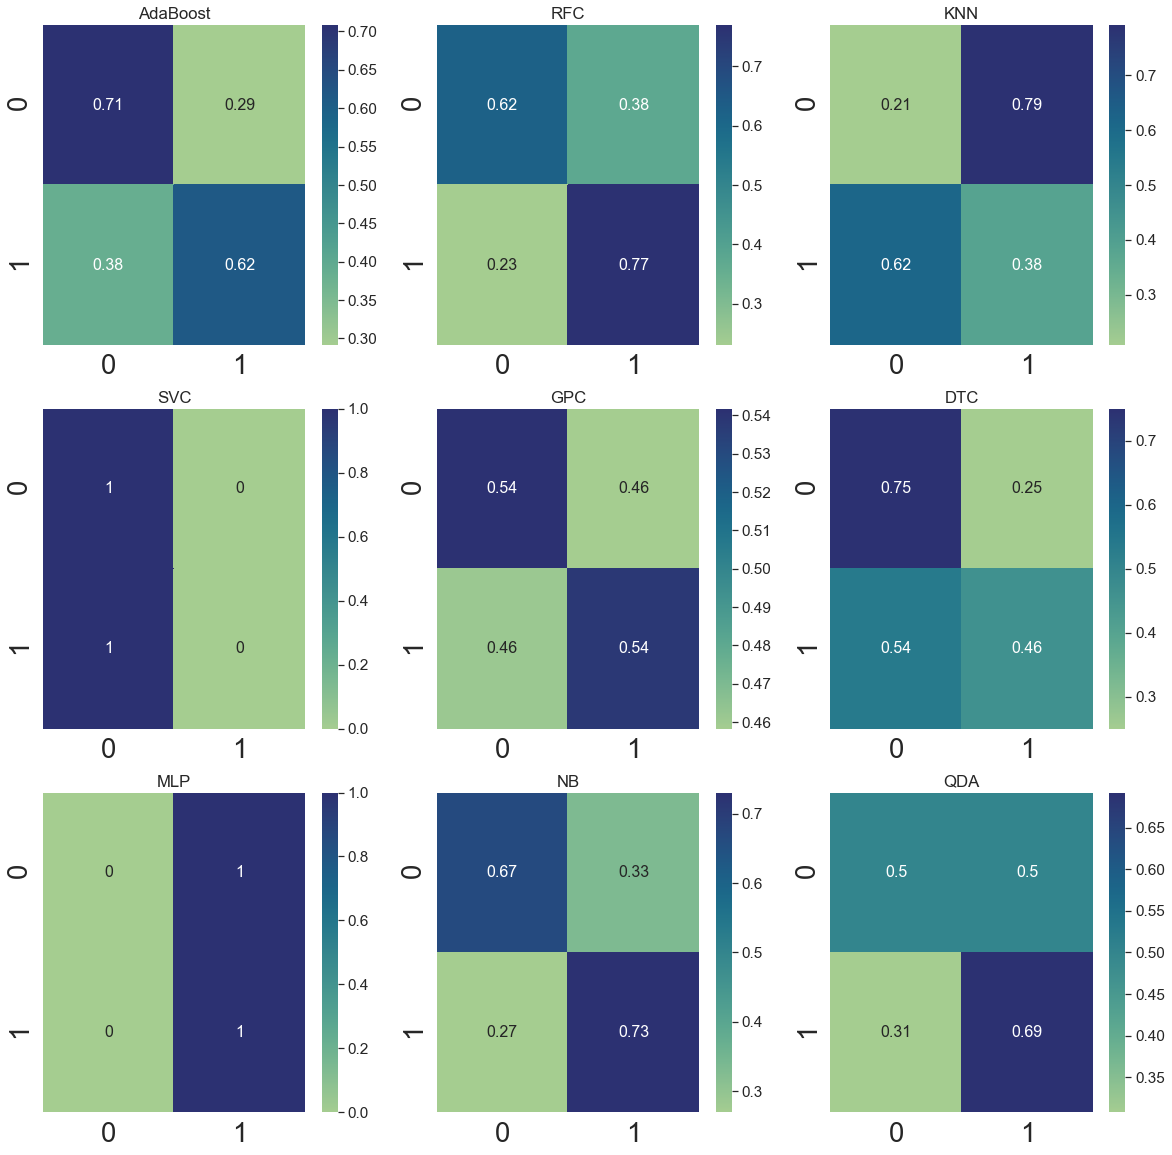

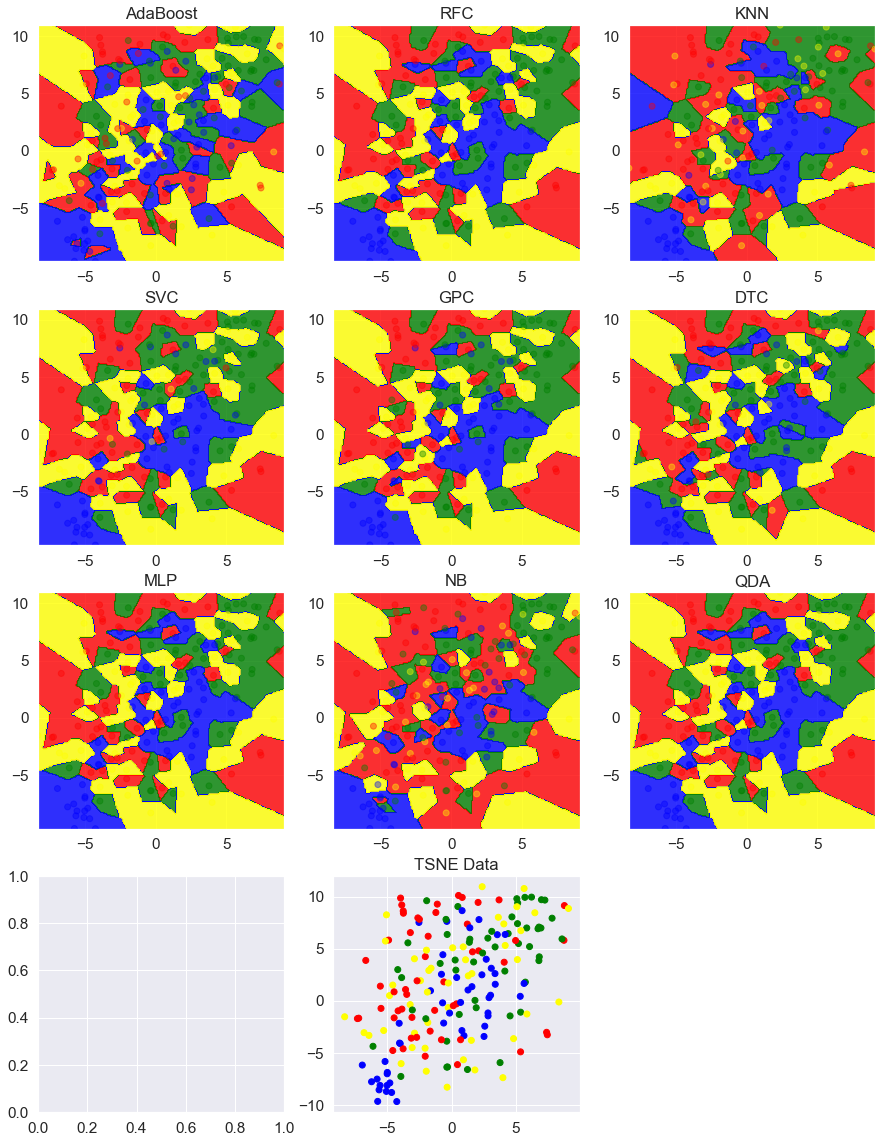

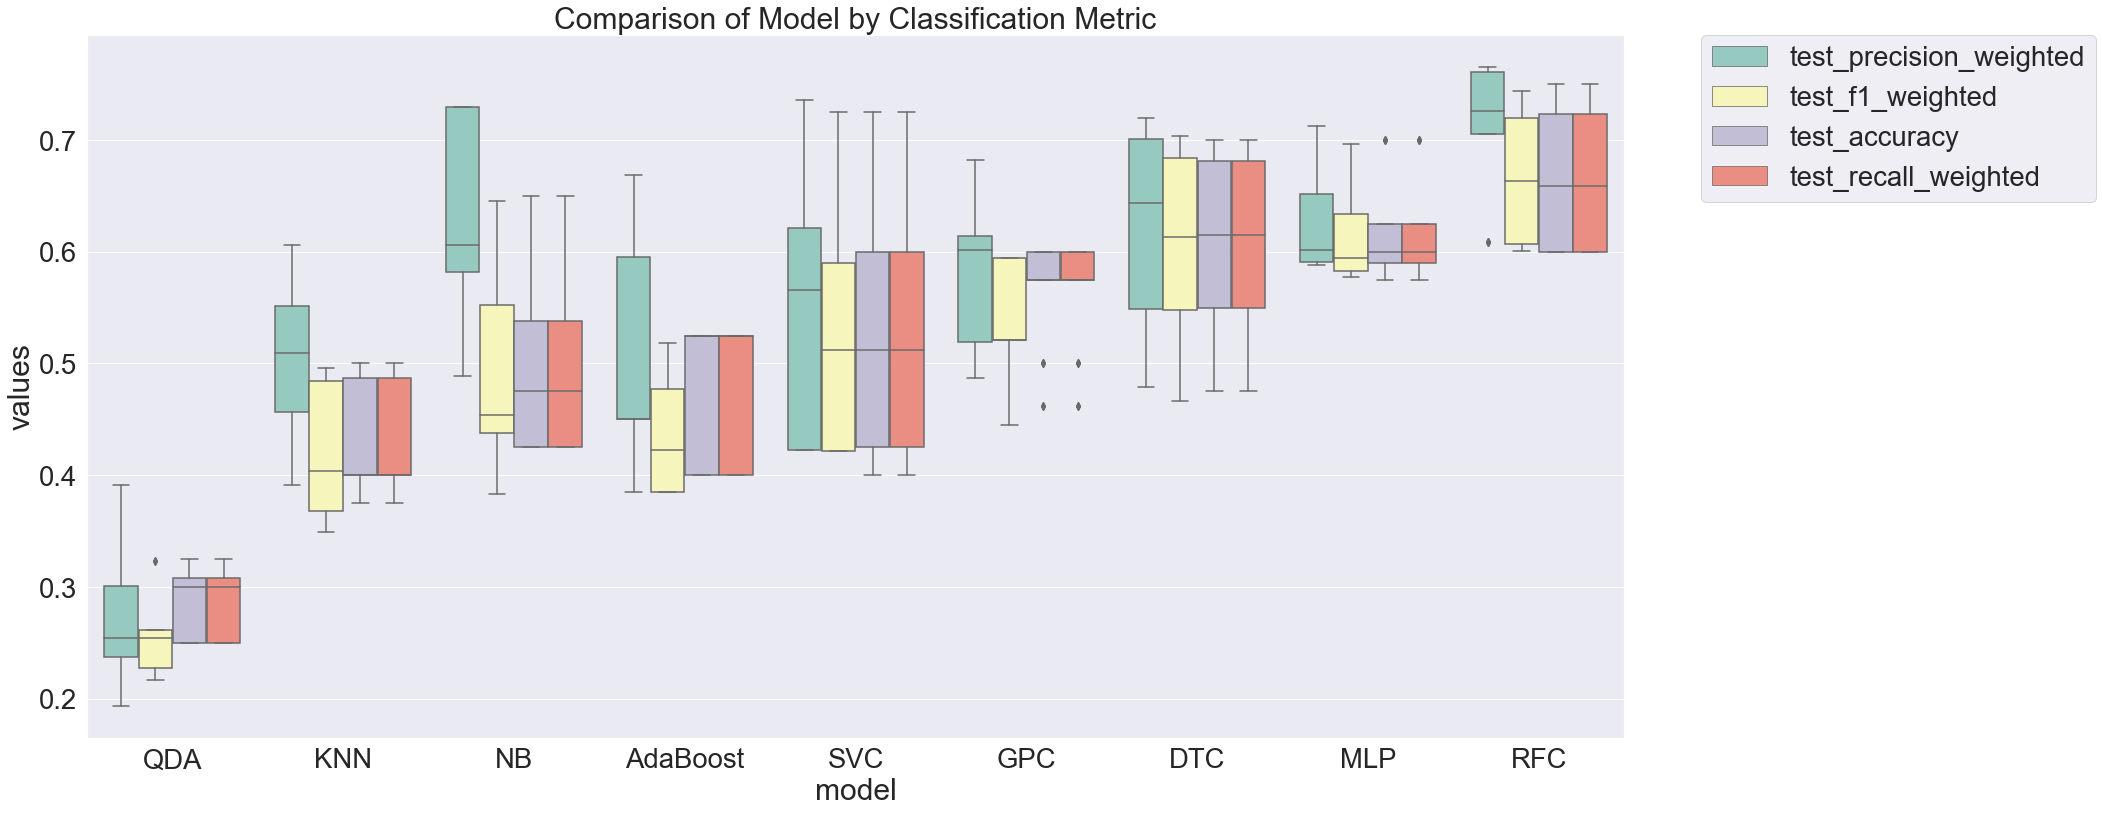

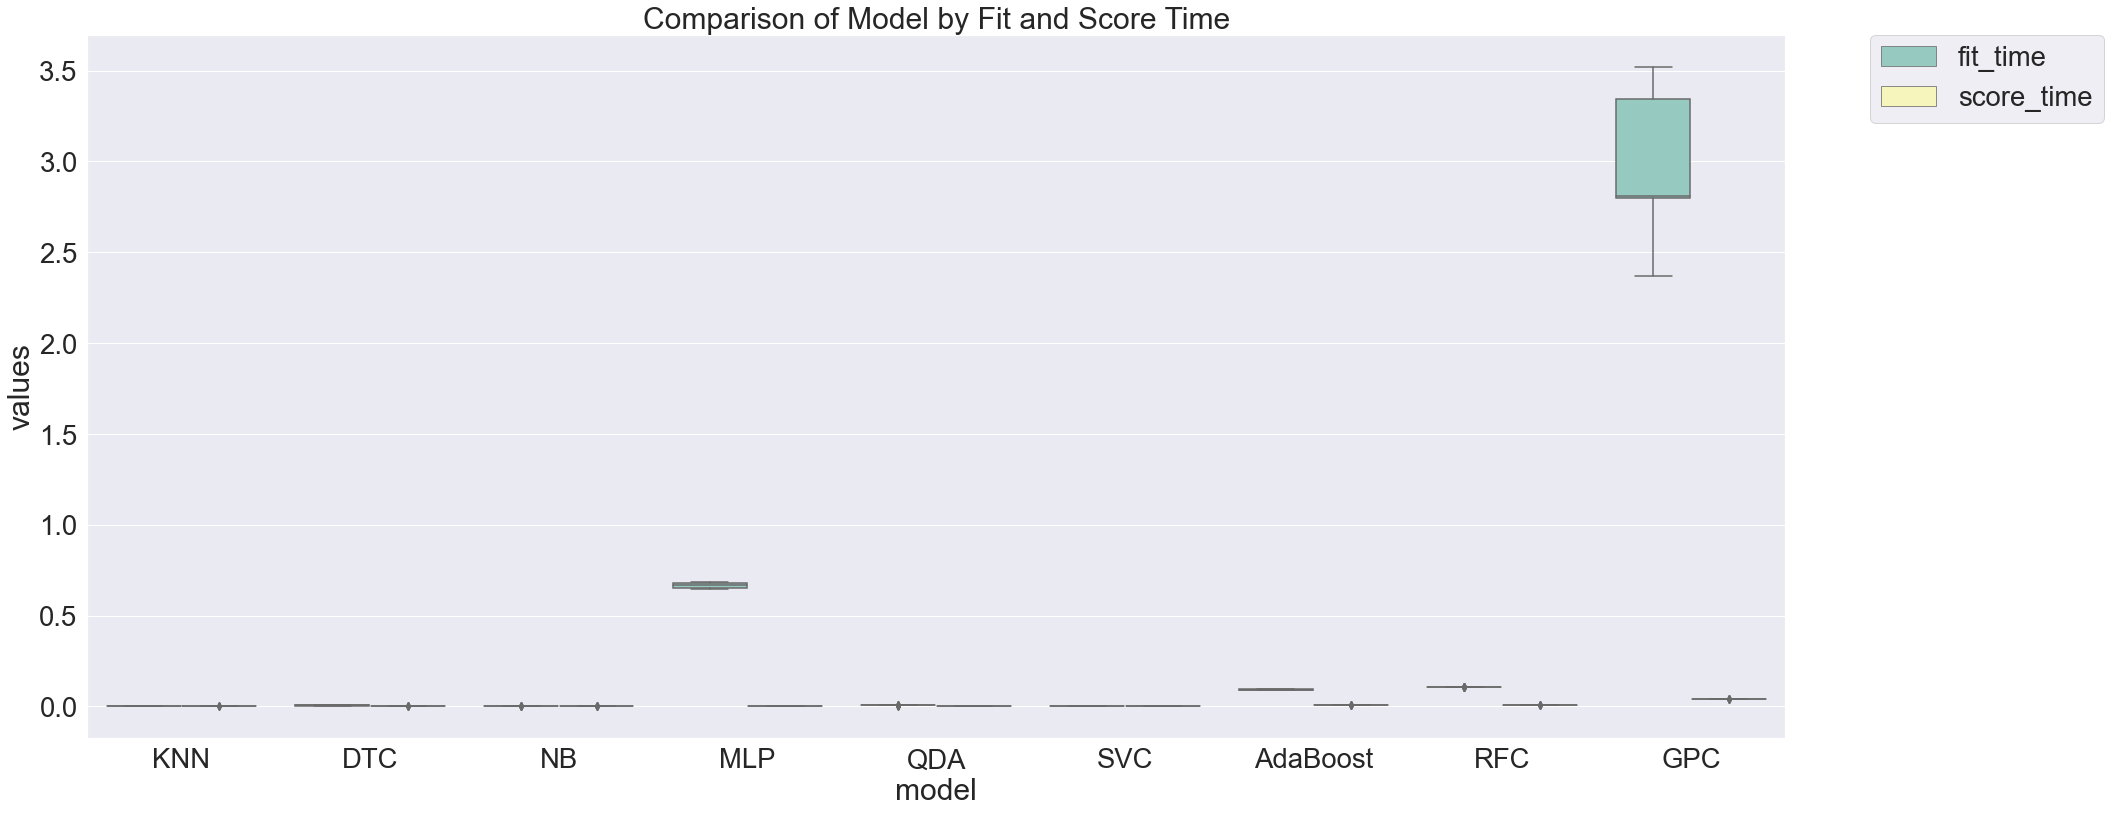

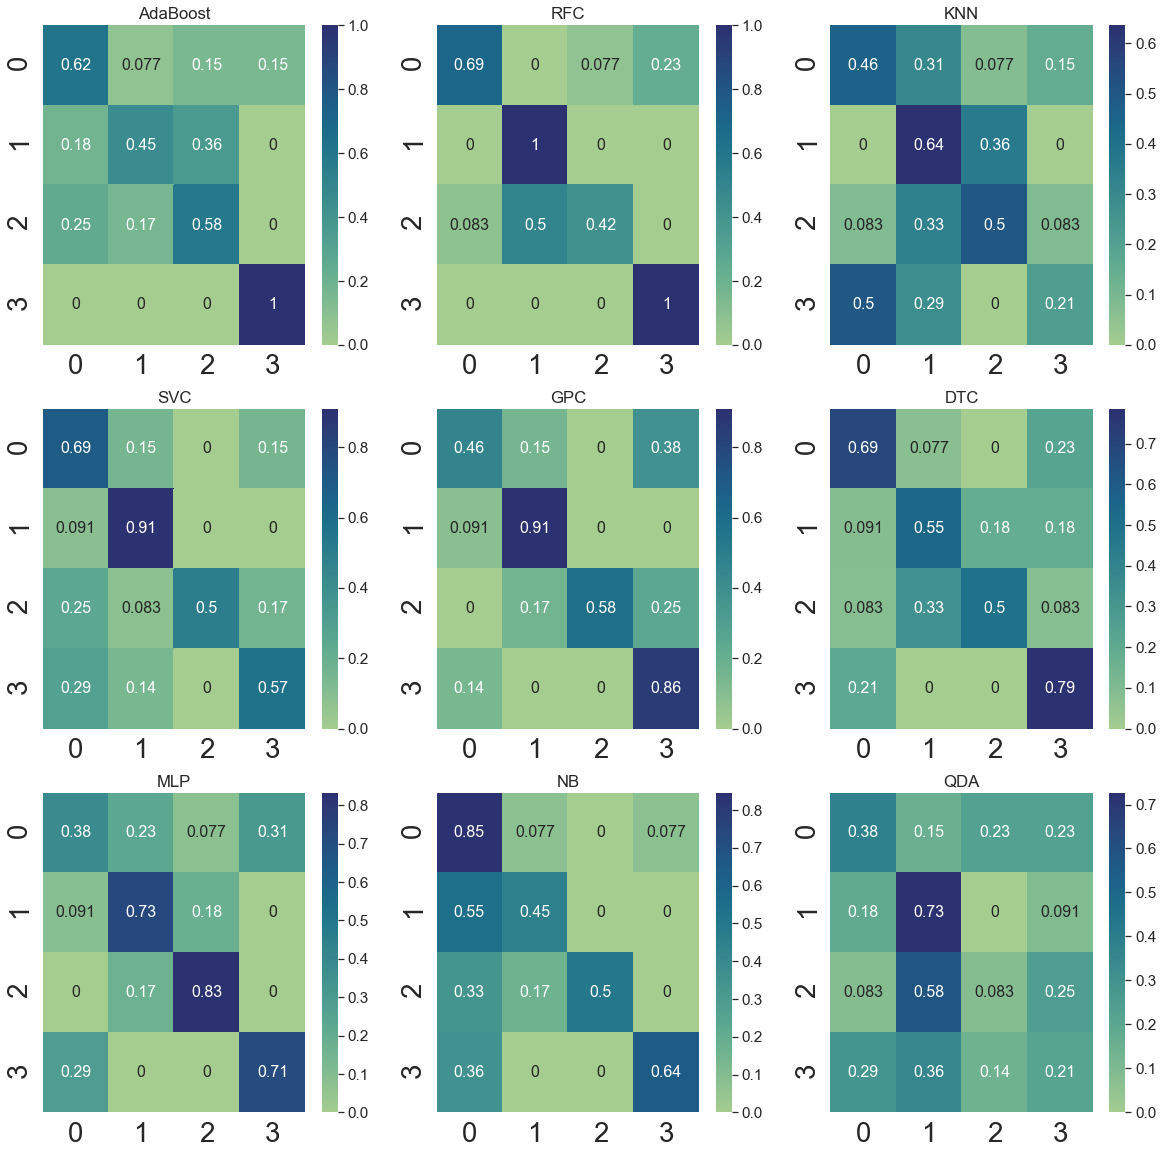

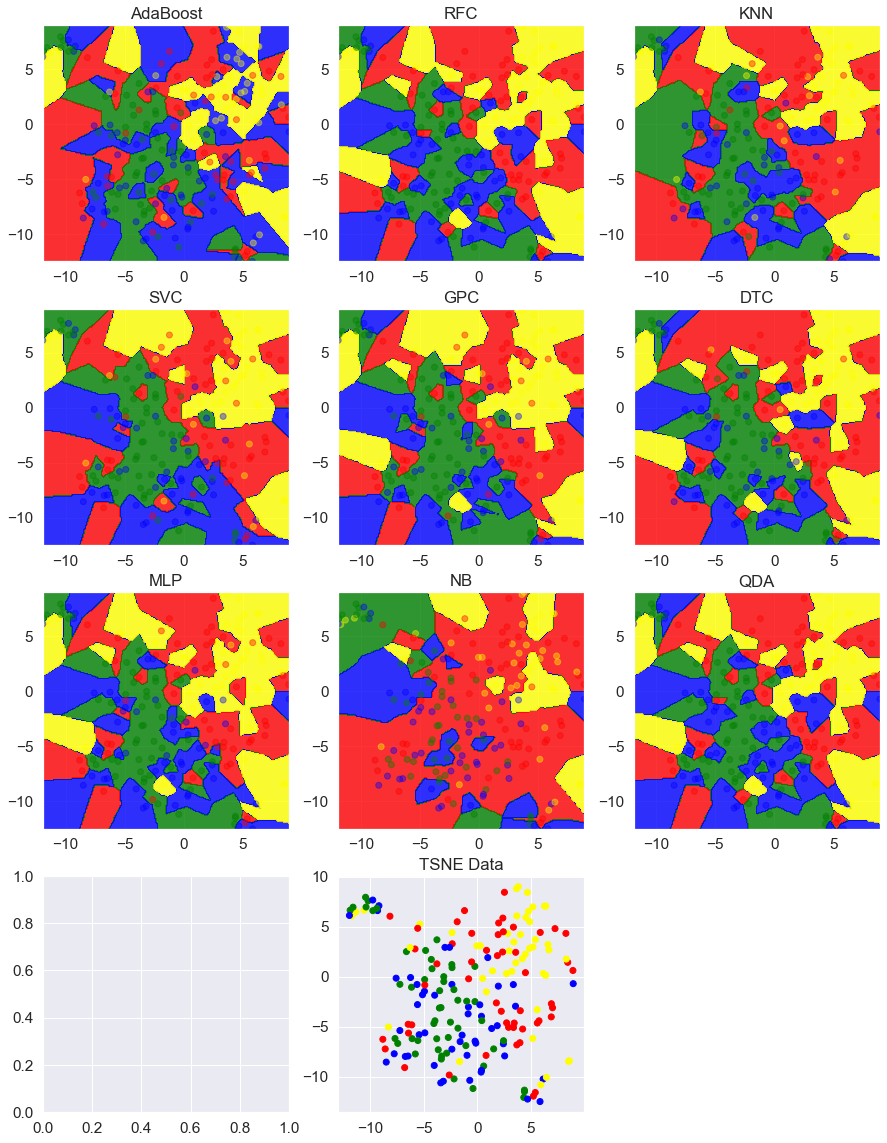

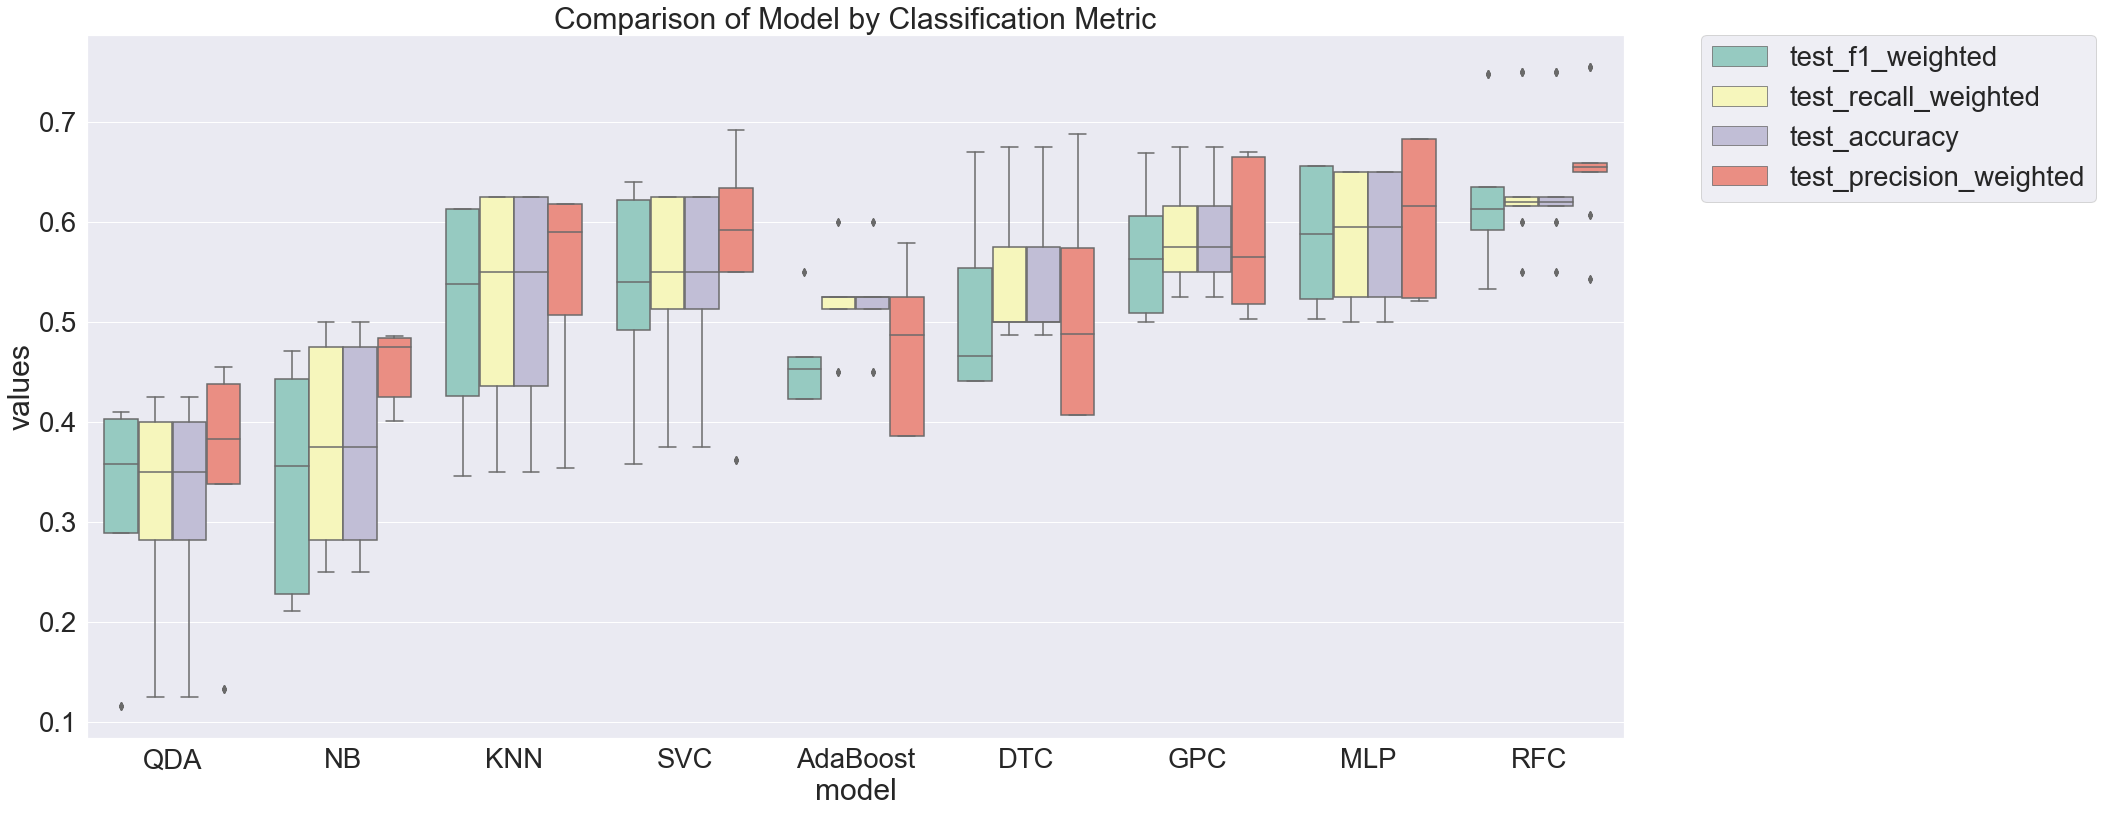

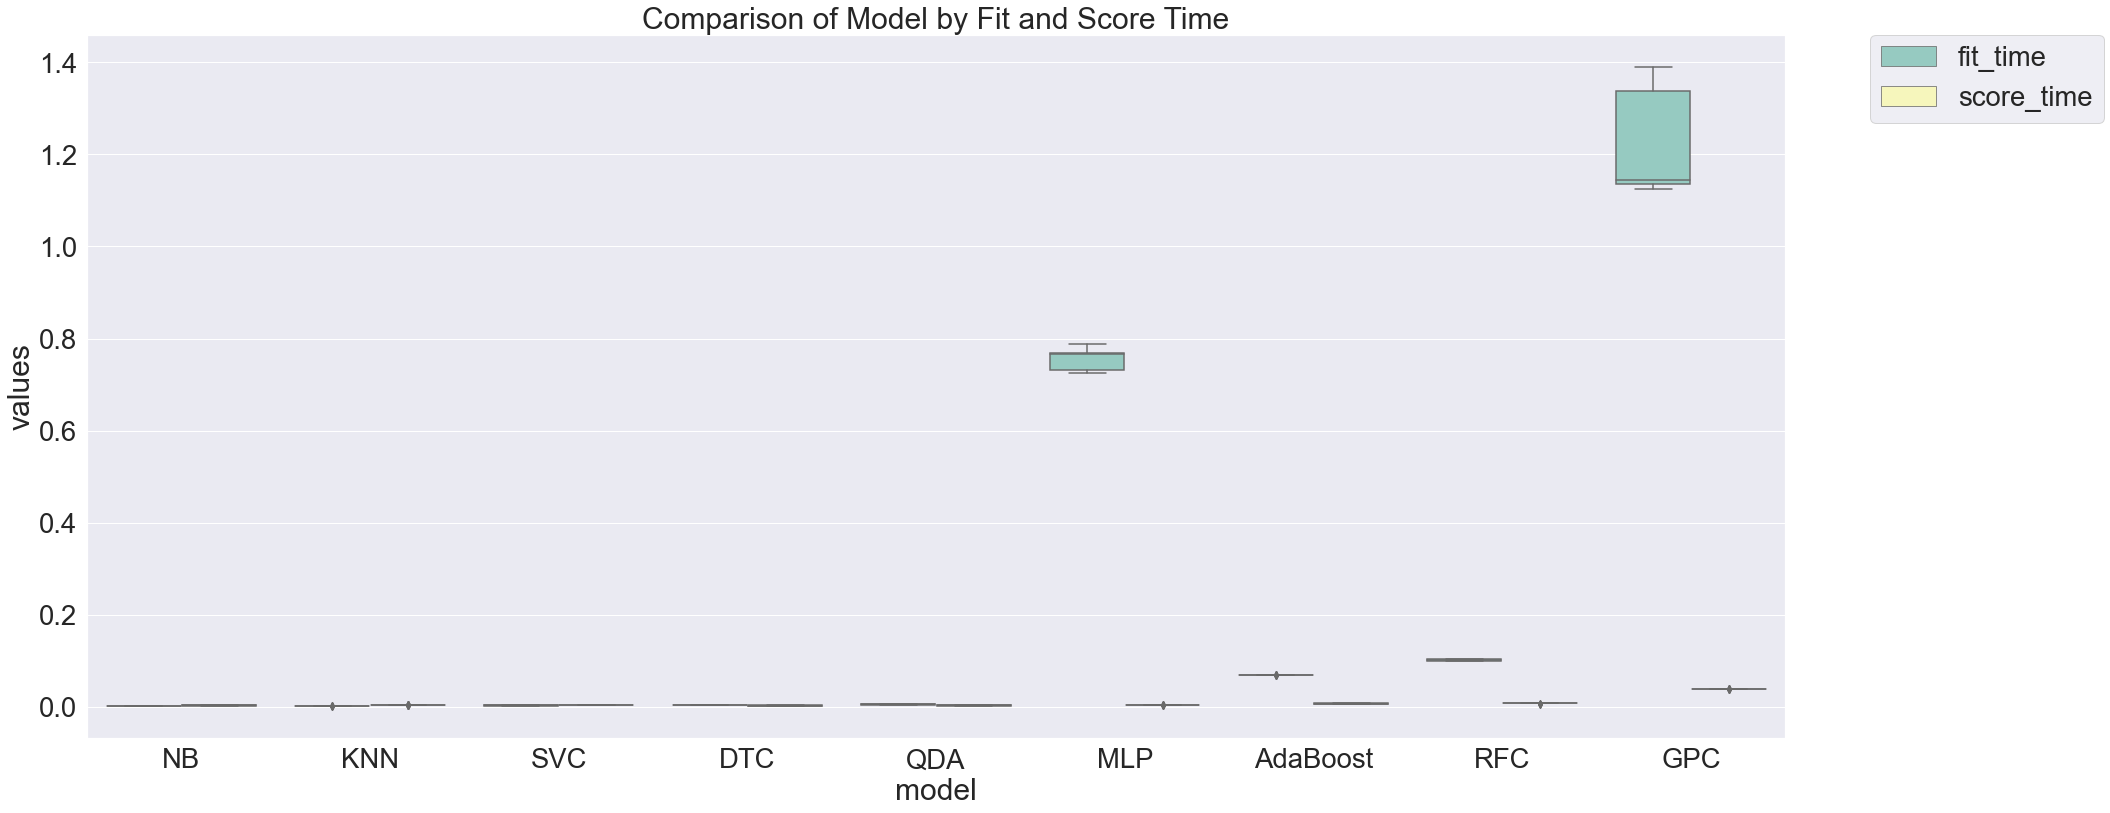

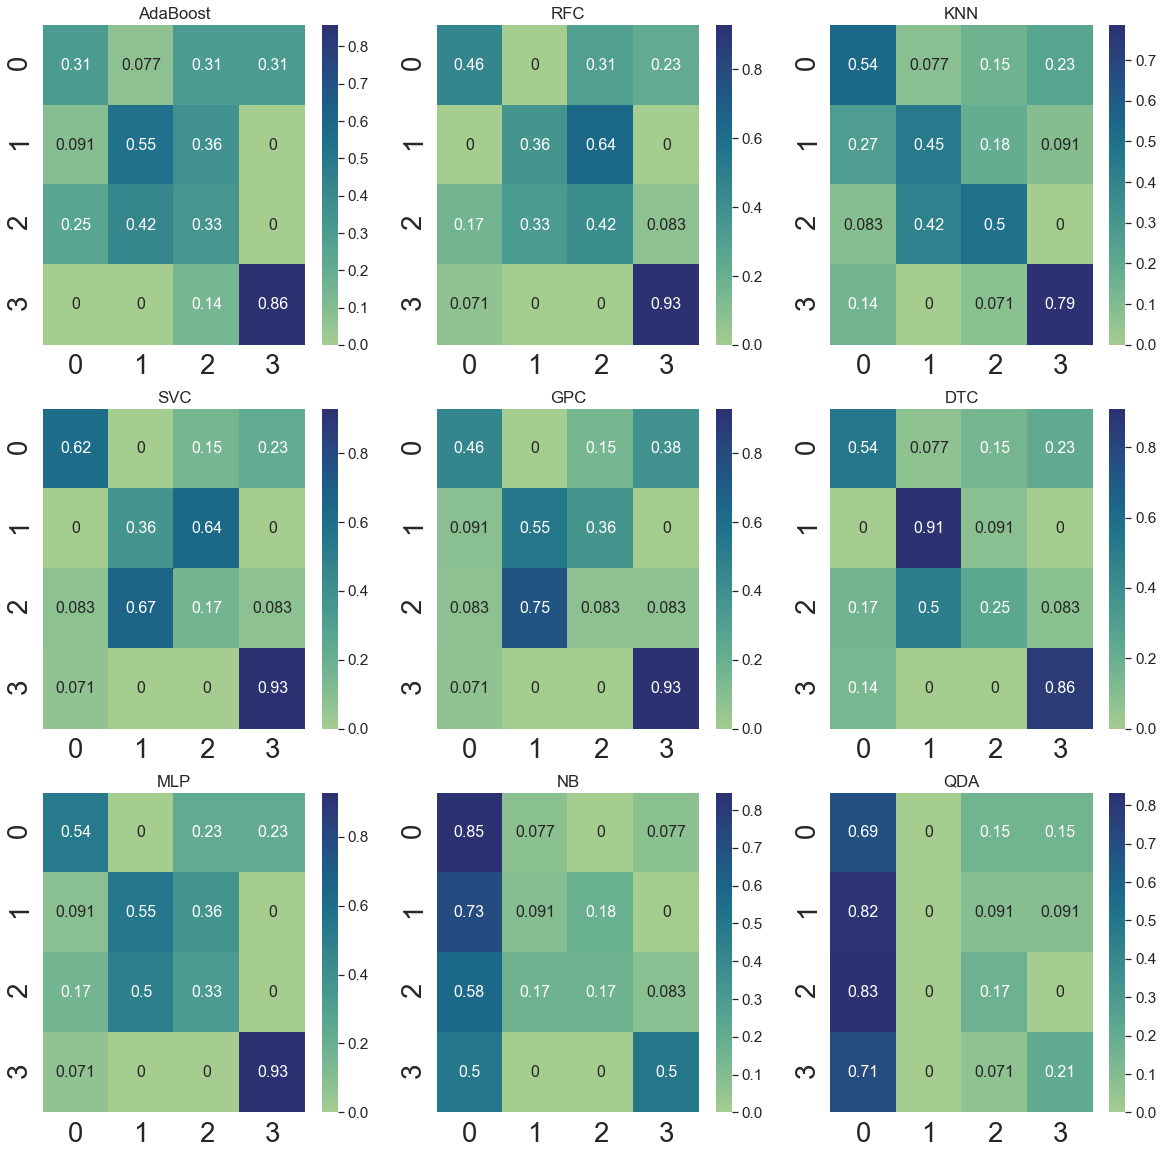

In [22]:
import performance_metrics #This python script does the machine learning across 9 algorithms, you pass in the name of the dataset and the location and it outputs results

results = {"databinary": "./processed_data/completeDatabinary.csv","databinarynoeye": "./processed_data/completeDatabinarynoeye.csv","completeData": "././processed_data/completeData.csv","ecggsr": "./processed_data/completeDatanoeye.csv"}
performance_metrics.main(results)


Hyperparameter tuning for the Binary Problem, using DTC and RFC

In [9]:

dataset = pd.read_csv("./processed_data/completeDatabinarynoeye.csv")

X = dataset.drop('labels', axis=1)
y = dataset['labels']
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [24]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

clf = RandomForestClassifier()

grid = GridSearchCV(estimator=clf, param_grid=param_grid,n_jobs=-1)
grid.fit(X_train, y_train)
print(grid)
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400,
                                          1600, 1800, 2000]})
0.7871020408163265
RandomForestClassifier(bootstrap=False, max_depth=40, max_features='sqrt',
                       min_samples_split=5, n_estimators=200)
{'bootstrap': False, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [10]:
param_grid = {
    'criterion': ["gini", "entropy"],
    'splitter': ["random","best"],
    'class_weight': ["blanced",None],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt','log2',None],
    'min_samples_leaf': [1, 2, 4,8,12,16,32],
    'min_samples_split': [2, 5, 10,15,20],
    'max_leaf_nodes': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, None]
}

clf = DecisionTreeClassifier()

grid = GridSearchCV(estimator=clf, param_grid=param_grid,n_jobs=-1)
grid.fit(X_train, y_train)
print(grid)
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['blanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       None],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'max_leaf_nodes': [200, 400, 600, 800, 1000, 1200,
                                            1400, 1600, 1800, 2000, None],
                         'min_samples_leaf': [1, 2, 4, 8, 12, 16, 32],
                         'min_samples_split': [2, 5, 10, 15, 20],
                         'splitter': ['random', 'best']})
0.7070204081632653
DecisionTreeClassifier(max_depth=10, max_features='log2', max_leaf_nodes=1400,
                       min_samples_leaf=8)
{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': 1400, 'min_samples_leaf': 8, 'mi

c:\users\tomje\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.55420408 0.57379592 0.55420408]
  warnings.warn(


Using the tuned Hyperparameters for new classififcation reports

D:\Users\tomje\Documents\CO620 Research\Python On Dataset\performance_metrics.py:145: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
D:\Users\tomje\Documents\CO620 Research\Python On Dataset\performance_metrics.py:145: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


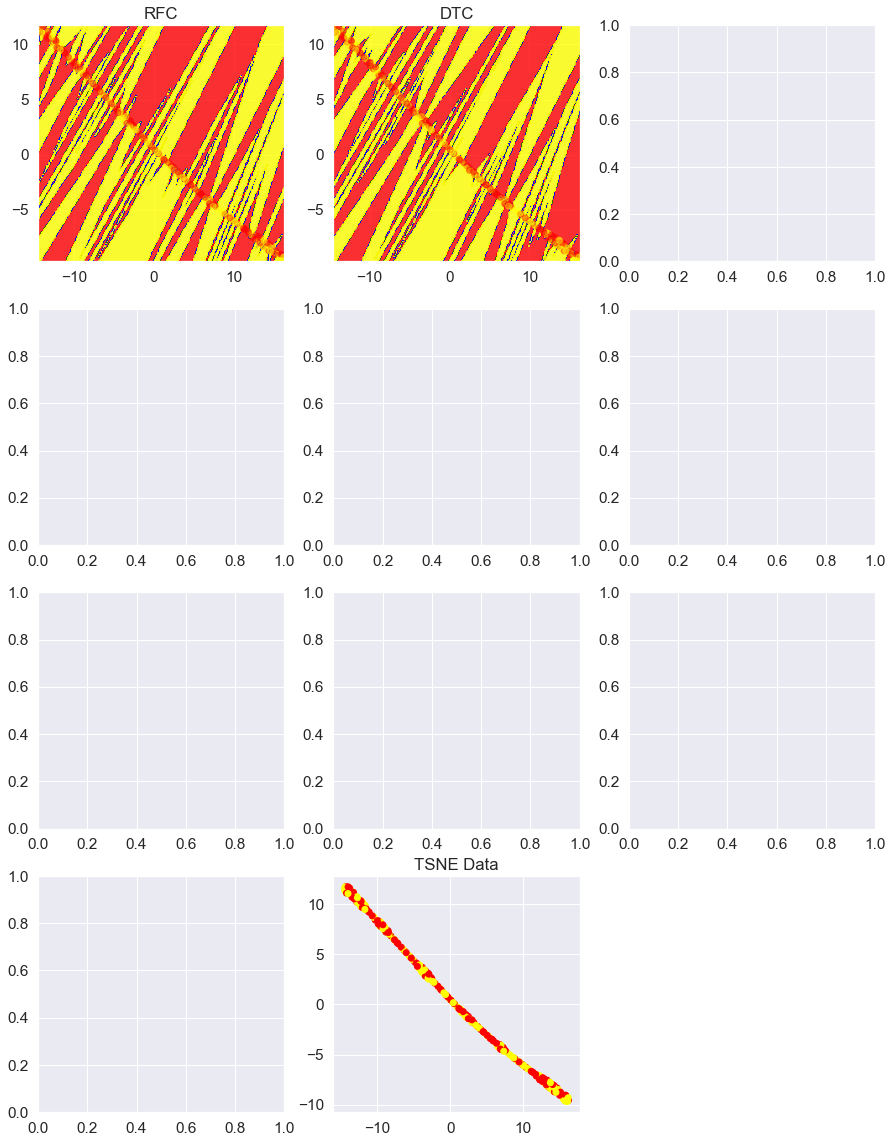

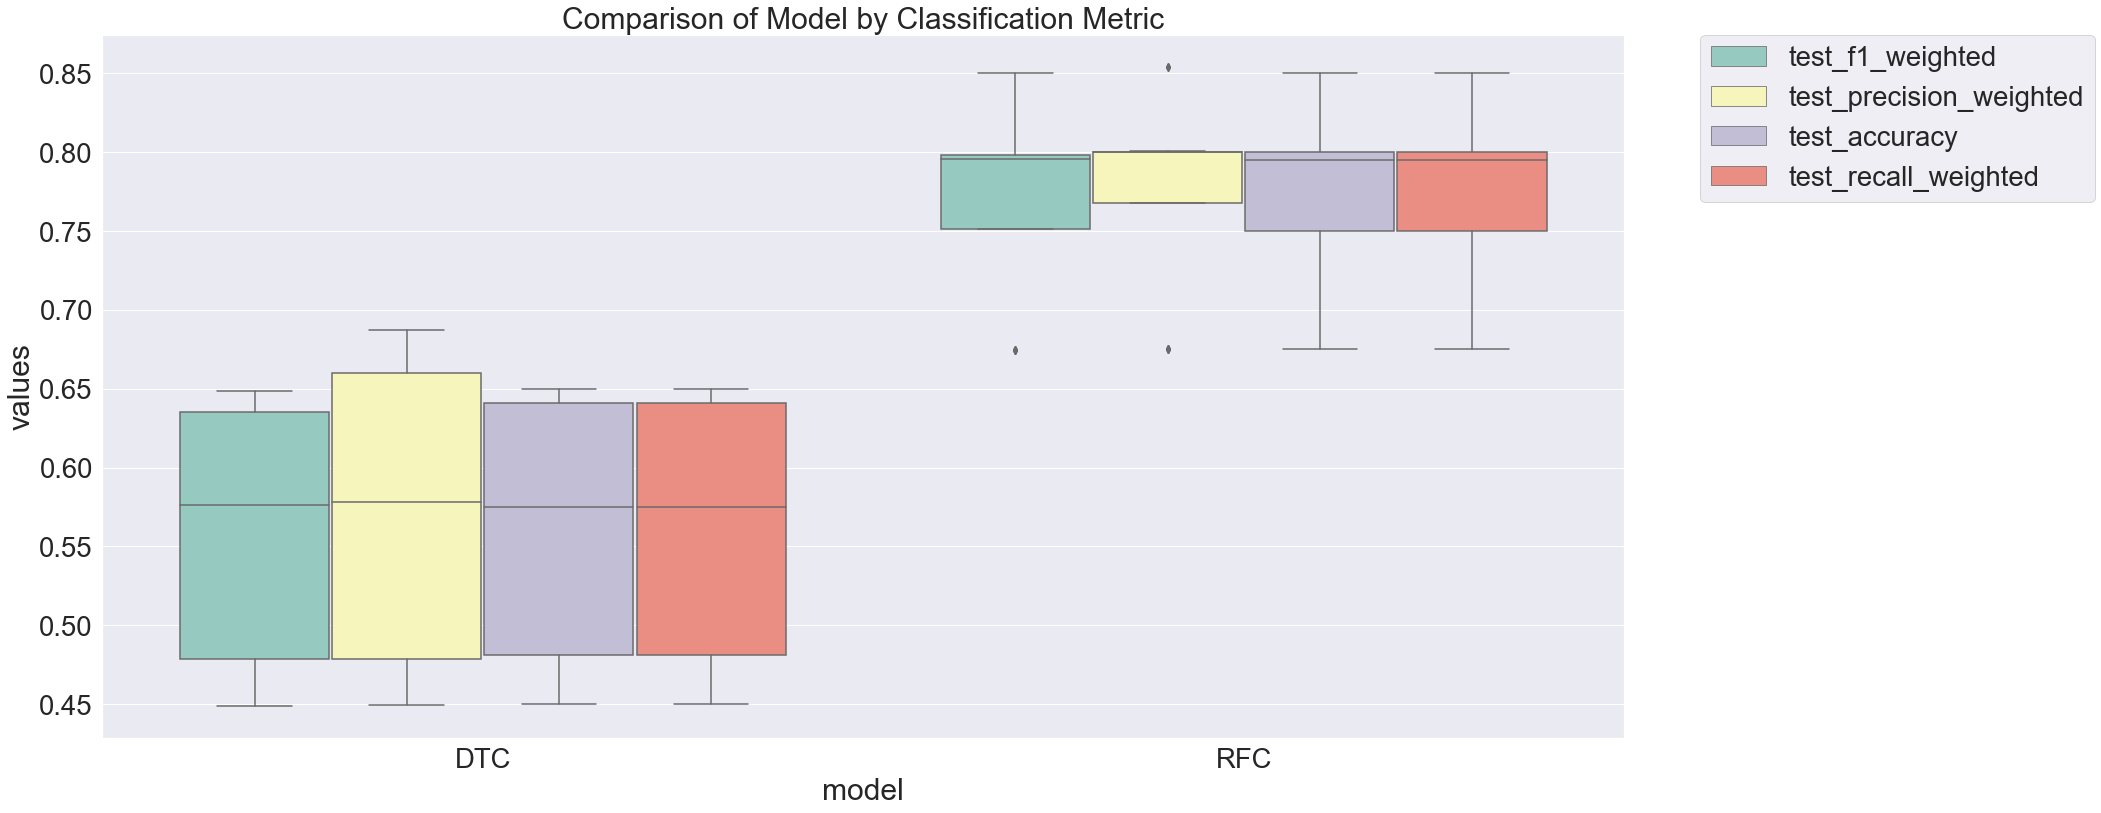

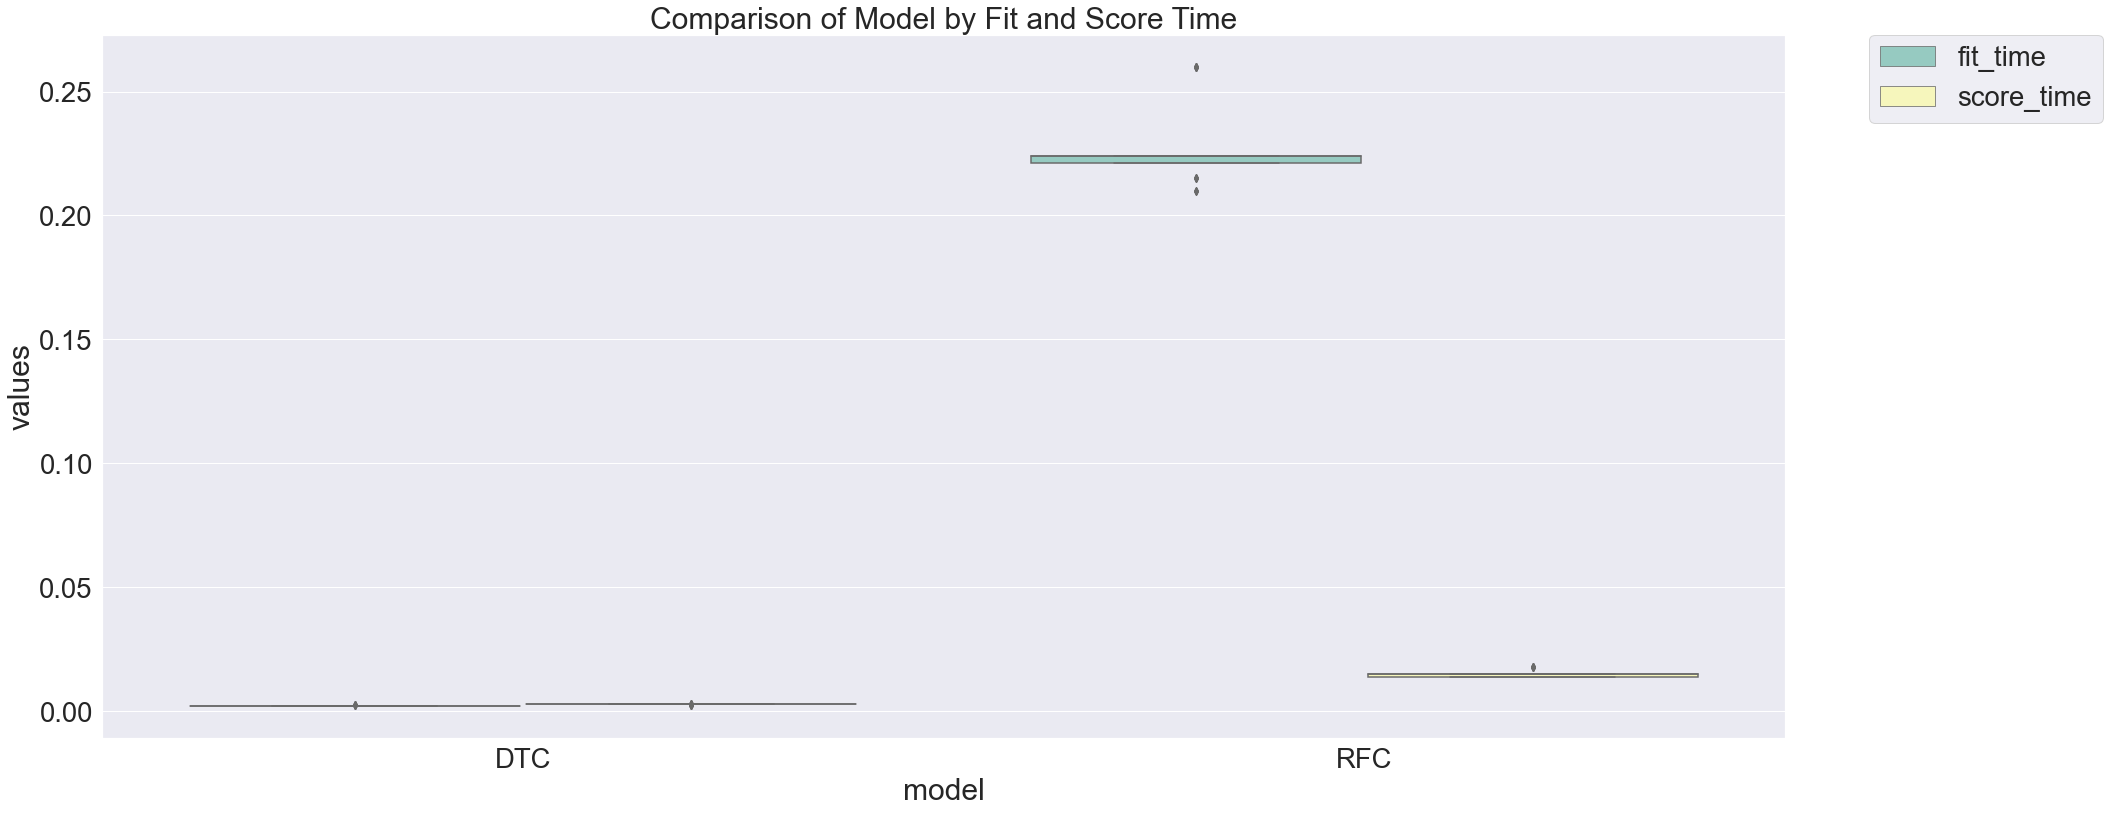

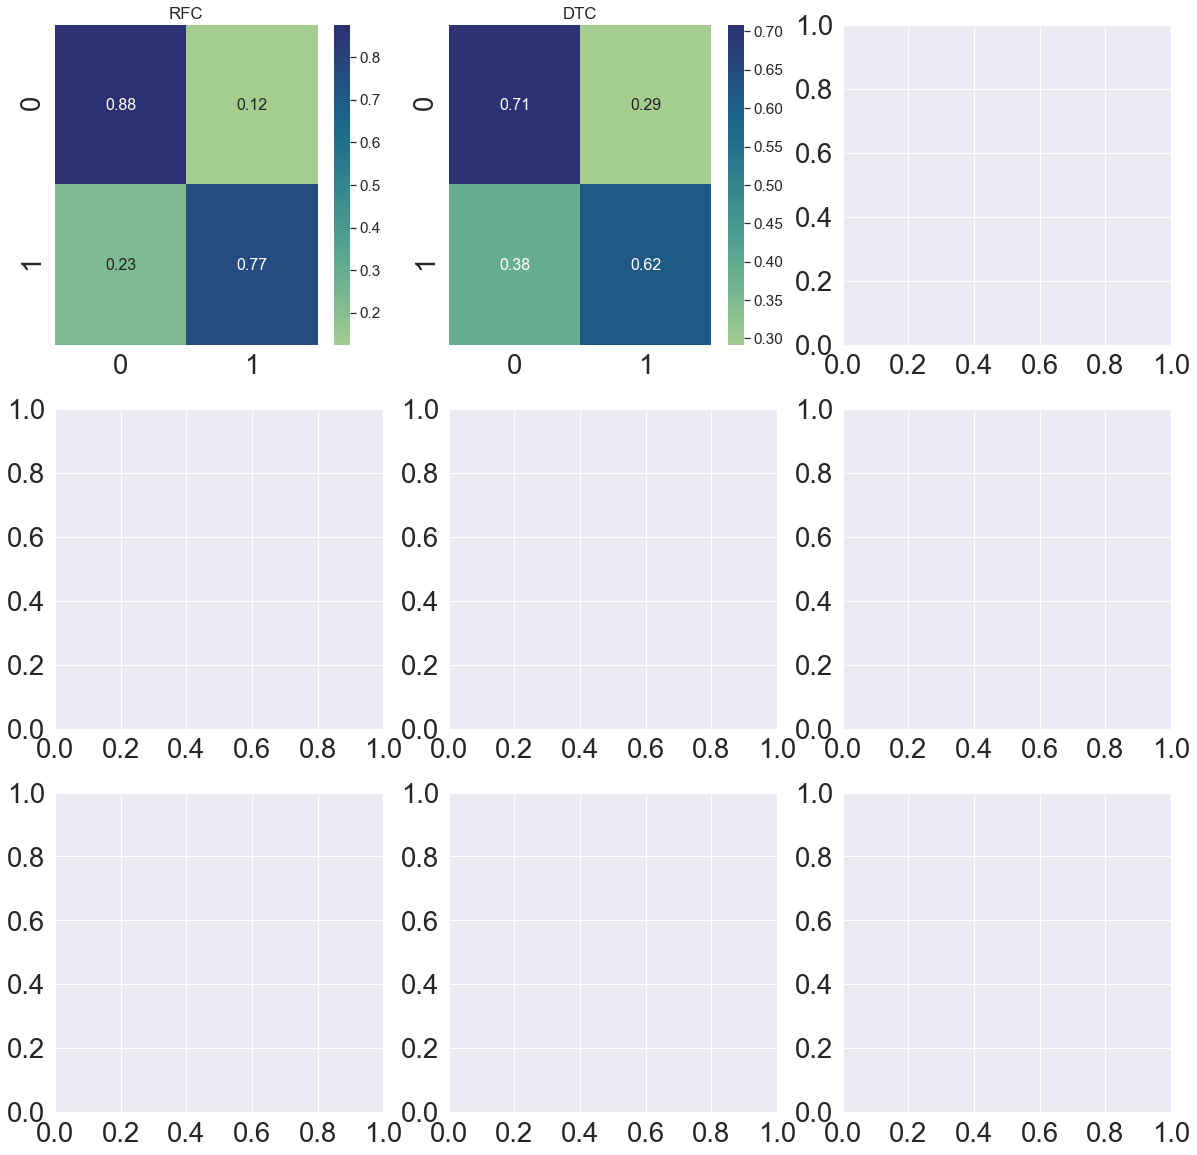

PermissionError: [Errno 13] Permission denied: './results/databinarynoeyetuned/report.csv'

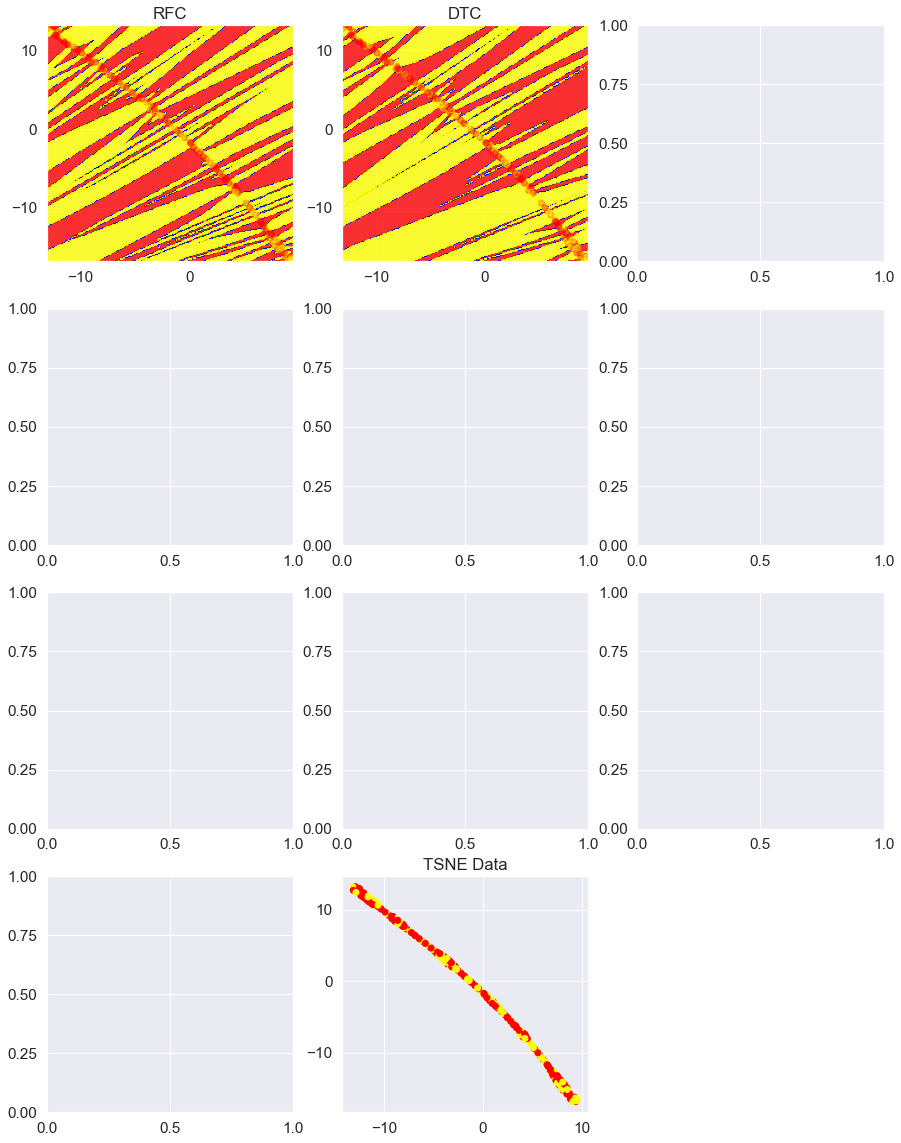

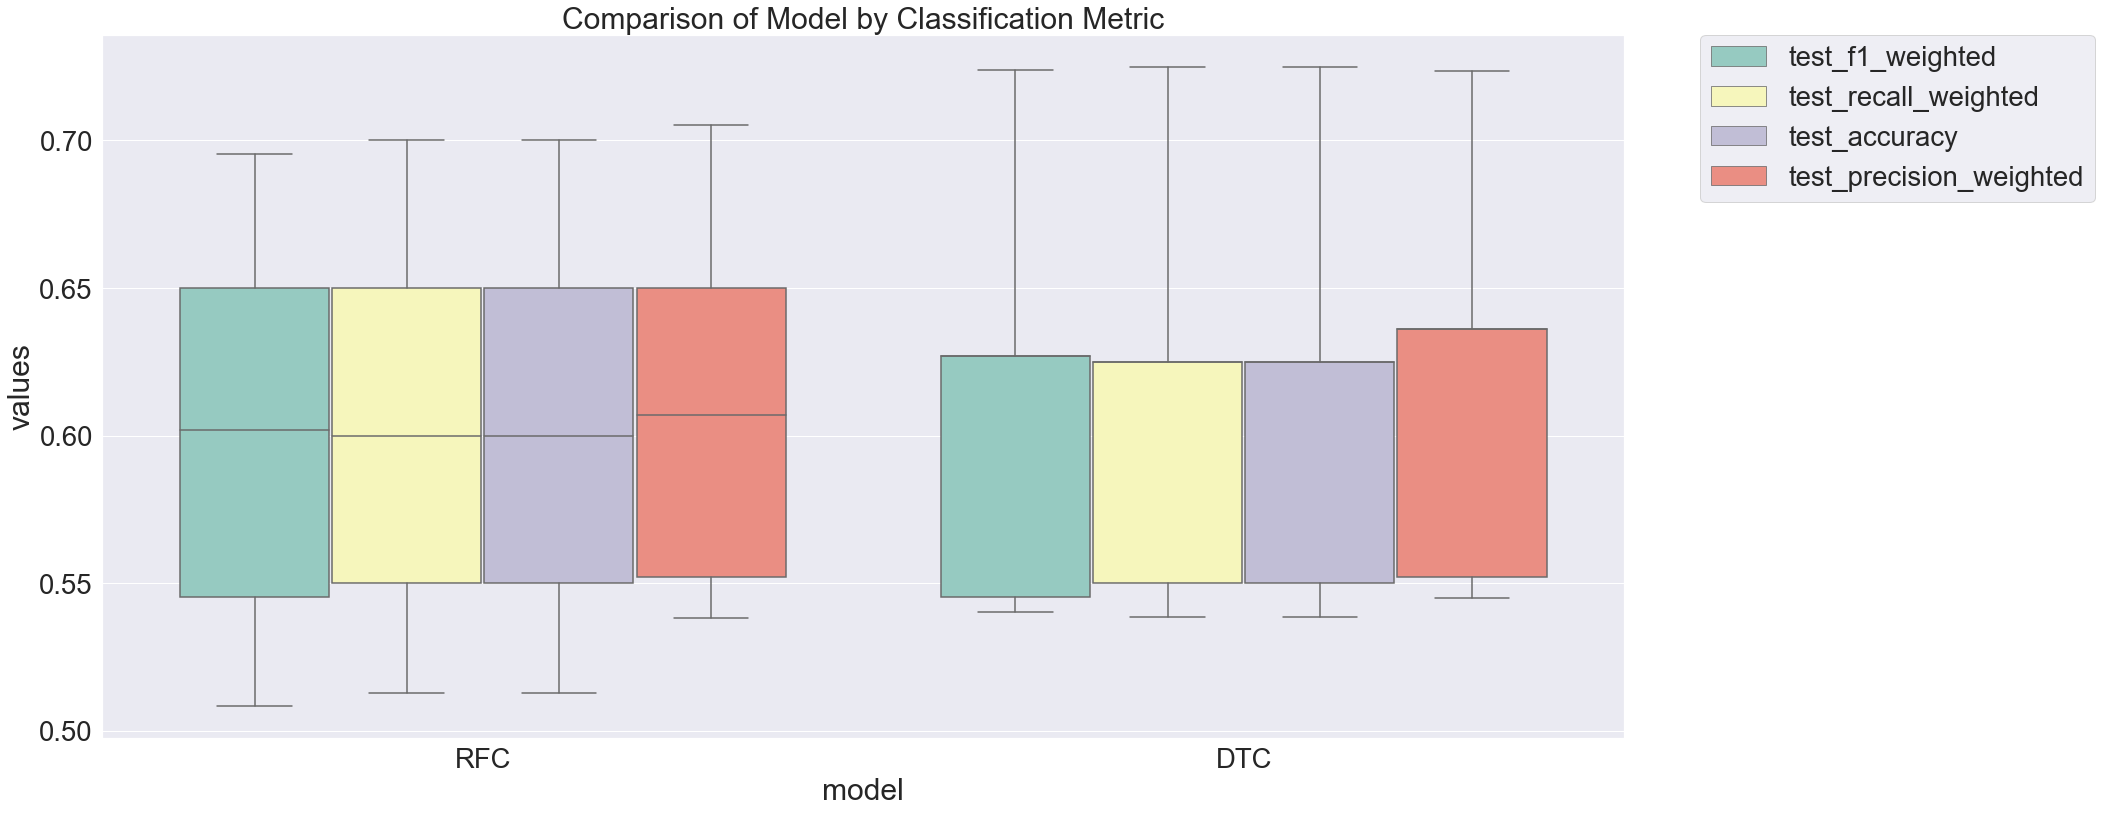

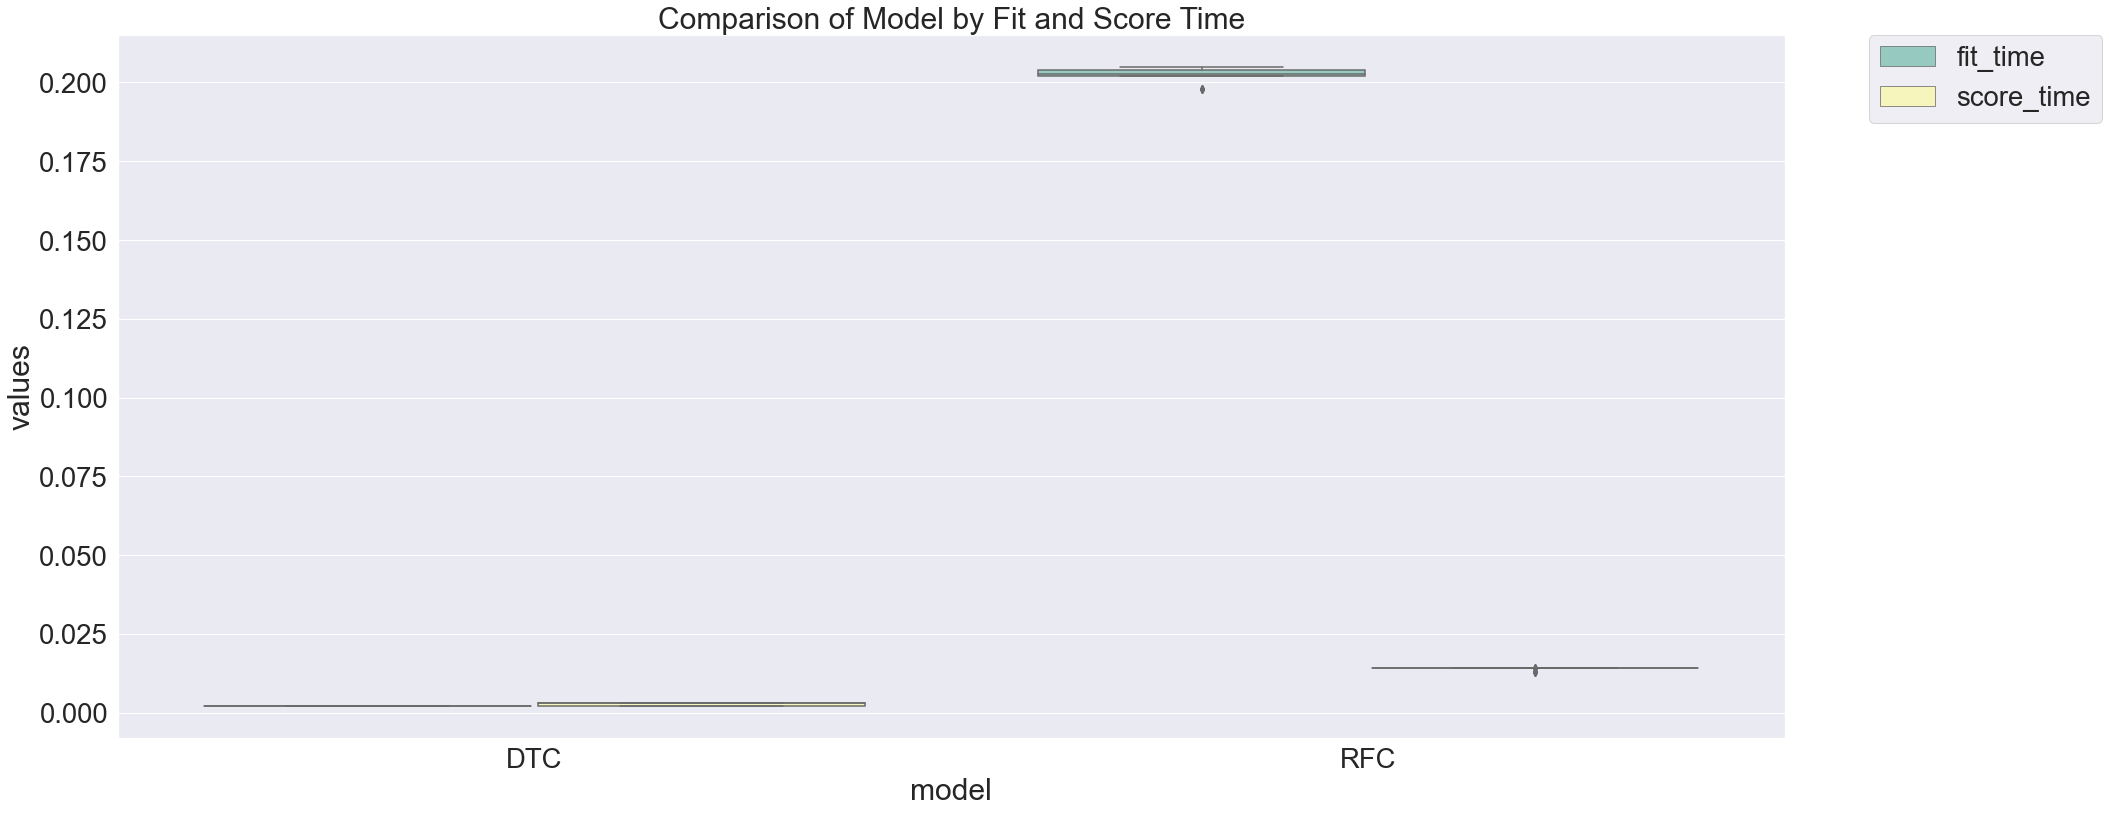

In [11]:
import performance_metrics
#best for binary with eye?
modelseye = [("RFC",RandomForestClassifier(bootstrap=False, max_depth=40, max_features='sqrt',
                       min_samples_split=5, n_estimators=200)),("DTC",DecisionTreeClassifier(max_depth=20, max_leaf_nodes=400, min_samples_leaf=12,
                       min_samples_split=20, splitter='random')),("SVC",SVC())]

models = [("RFC",RandomForestClassifier(bootstrap=False, max_depth=40, max_features='sqrt',
                       min_samples_split=5, n_estimators=200)),("DTC",DecisionTreeClassifier(max_depth=10, max_features='log2', max_leaf_nodes=1400,
                       min_samples_leaf=8)),("SVC",SVC())]
results = {"databinarytuned": "./processed_data/completeDatabinary.csv","databinarynoeyetuned": "./processed_data/completeDatabinarynoeye.csv"}
performance_metrics.main(results, models)

Hyperparameter tuning for 4 class problem

In [6]:
dataset = pd.read_csv("./processed_data/completeDatabinaryarous.csv")
dataset.dropna()

X = dataset.drop('labels', axis=1)
y = dataset['labels']
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)



In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [ 30, 40, 50, 60, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 800, 1000, 1200, 2000]
}

clf = RandomForestClassifier()

grid = GridSearchCV(estimator=clf, param_grid=param_grid,n_jobs=-1)
grid.fit(X_train, y_train)
print(grid)
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

In [13]:
param_grid = {
    'activation': ["identity", "logistic", "tanh", "relu"],
    'batch_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, "auto"],
    'learning_rate': ['constant', 'invscaling','adaptive'],
    'max_iter': [100, 200, 400,600,1000,2000],
}

clf = MLPClassifier()

grid = GridSearchCV(estimator=clf, param_grid=param_grid,n_jobs=-1)
grid.fit(X_train, y_train)
print(grid)
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'batch_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                        'auto'],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [100, 200, 400, 600, 1000, 2000]})
0.722857142857143
MLPClassifier(activation='logistic', batch_size=20, learning_rate='adaptive',
              max_iter=100)
{'activation': 'logistic', 'batch_size': 20, 'learning_rate': 'adaptive', 'max_iter': 100}


c:\users\tomje\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\users\tomje\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\tomje\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\tomje\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\tomje\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

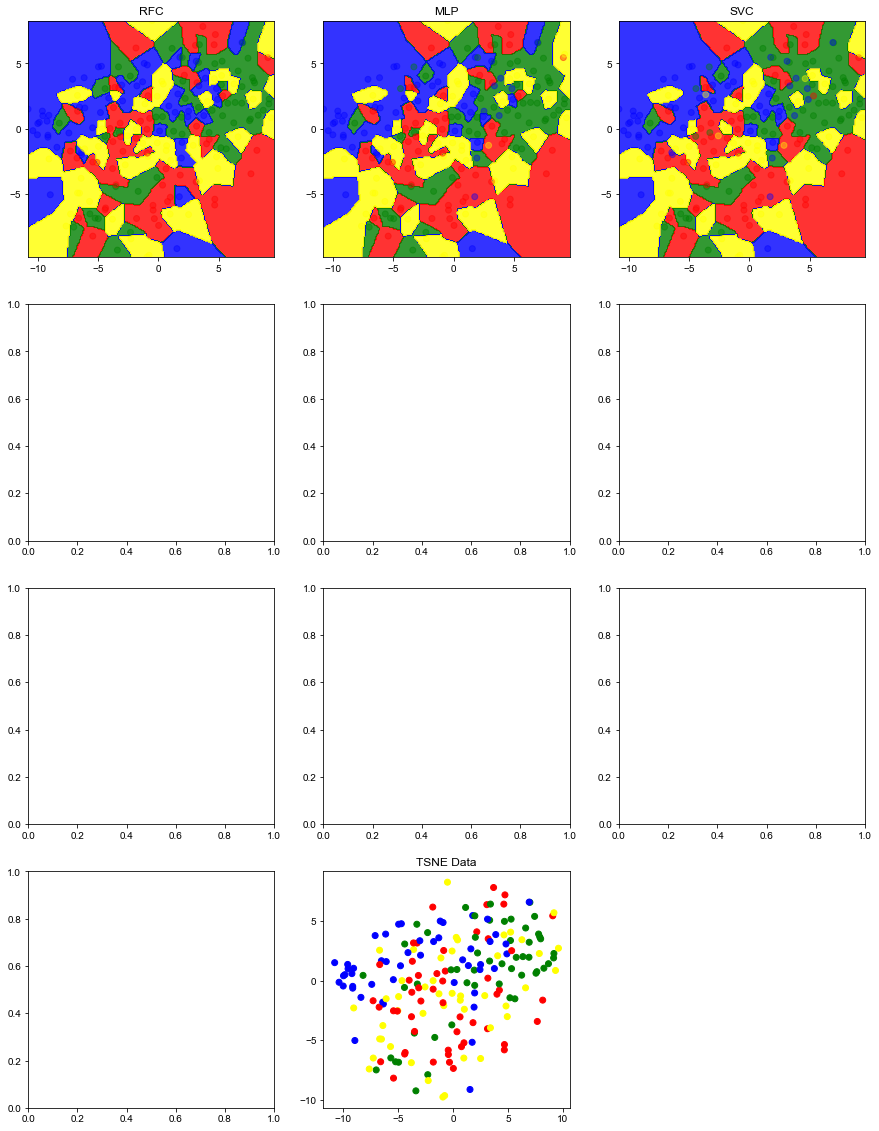

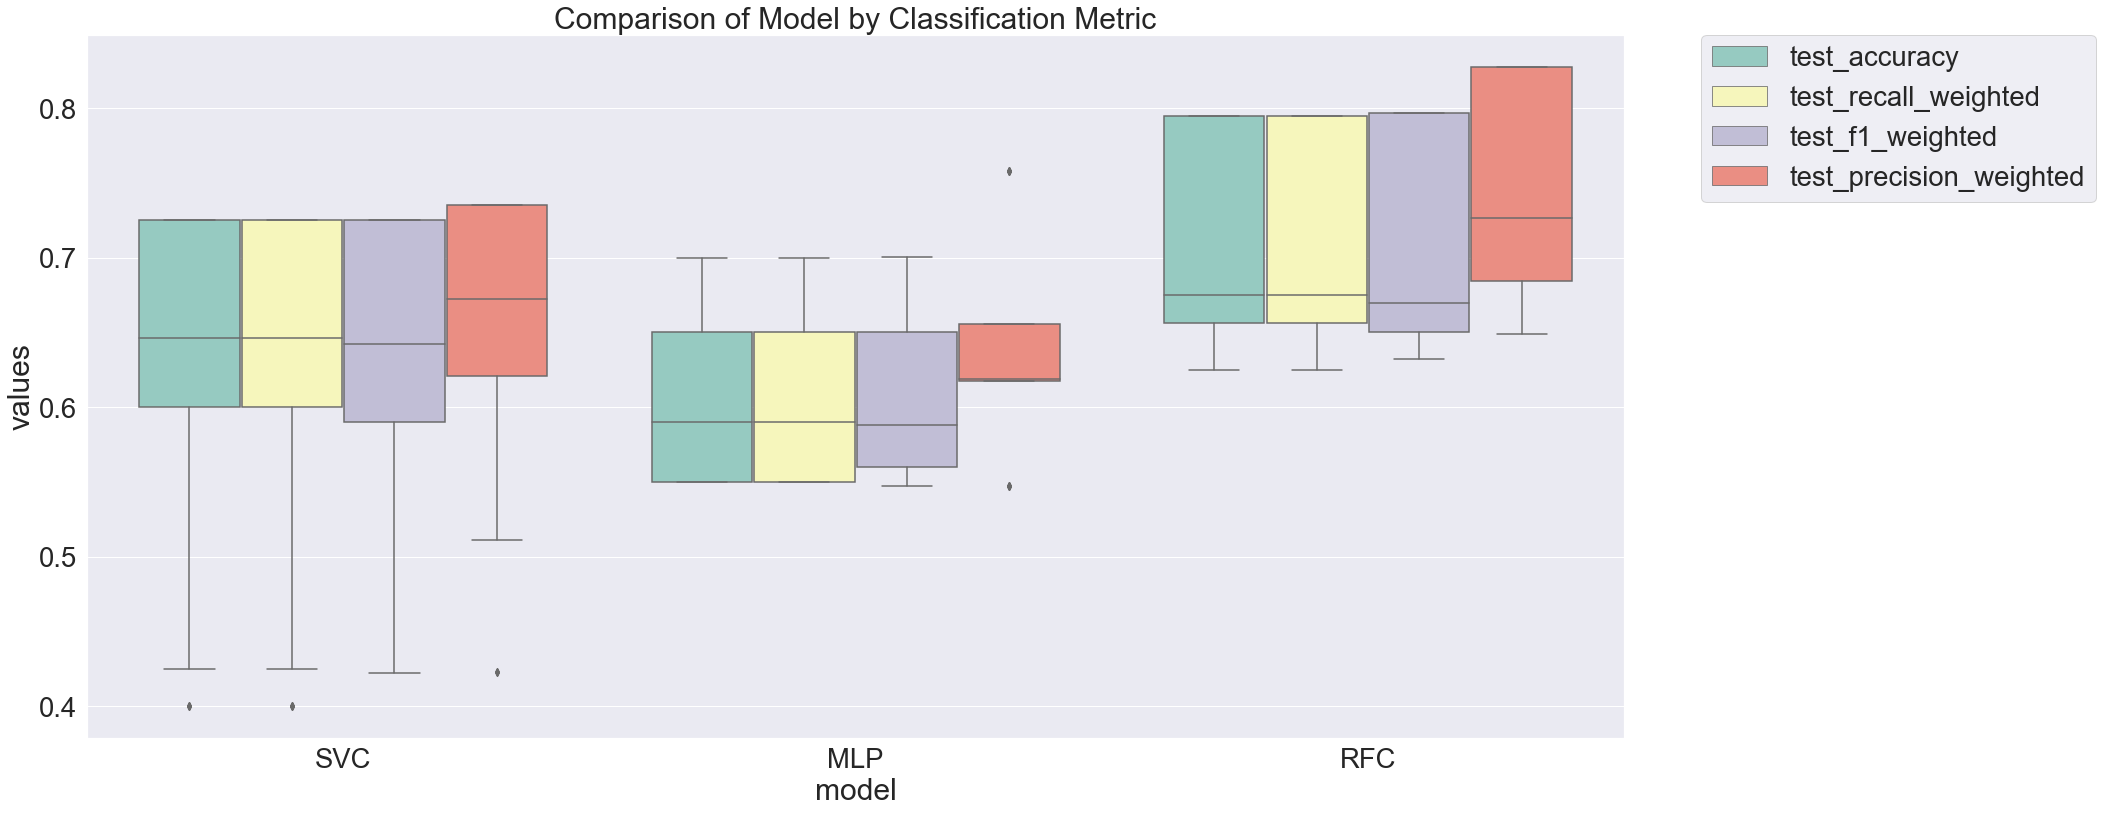

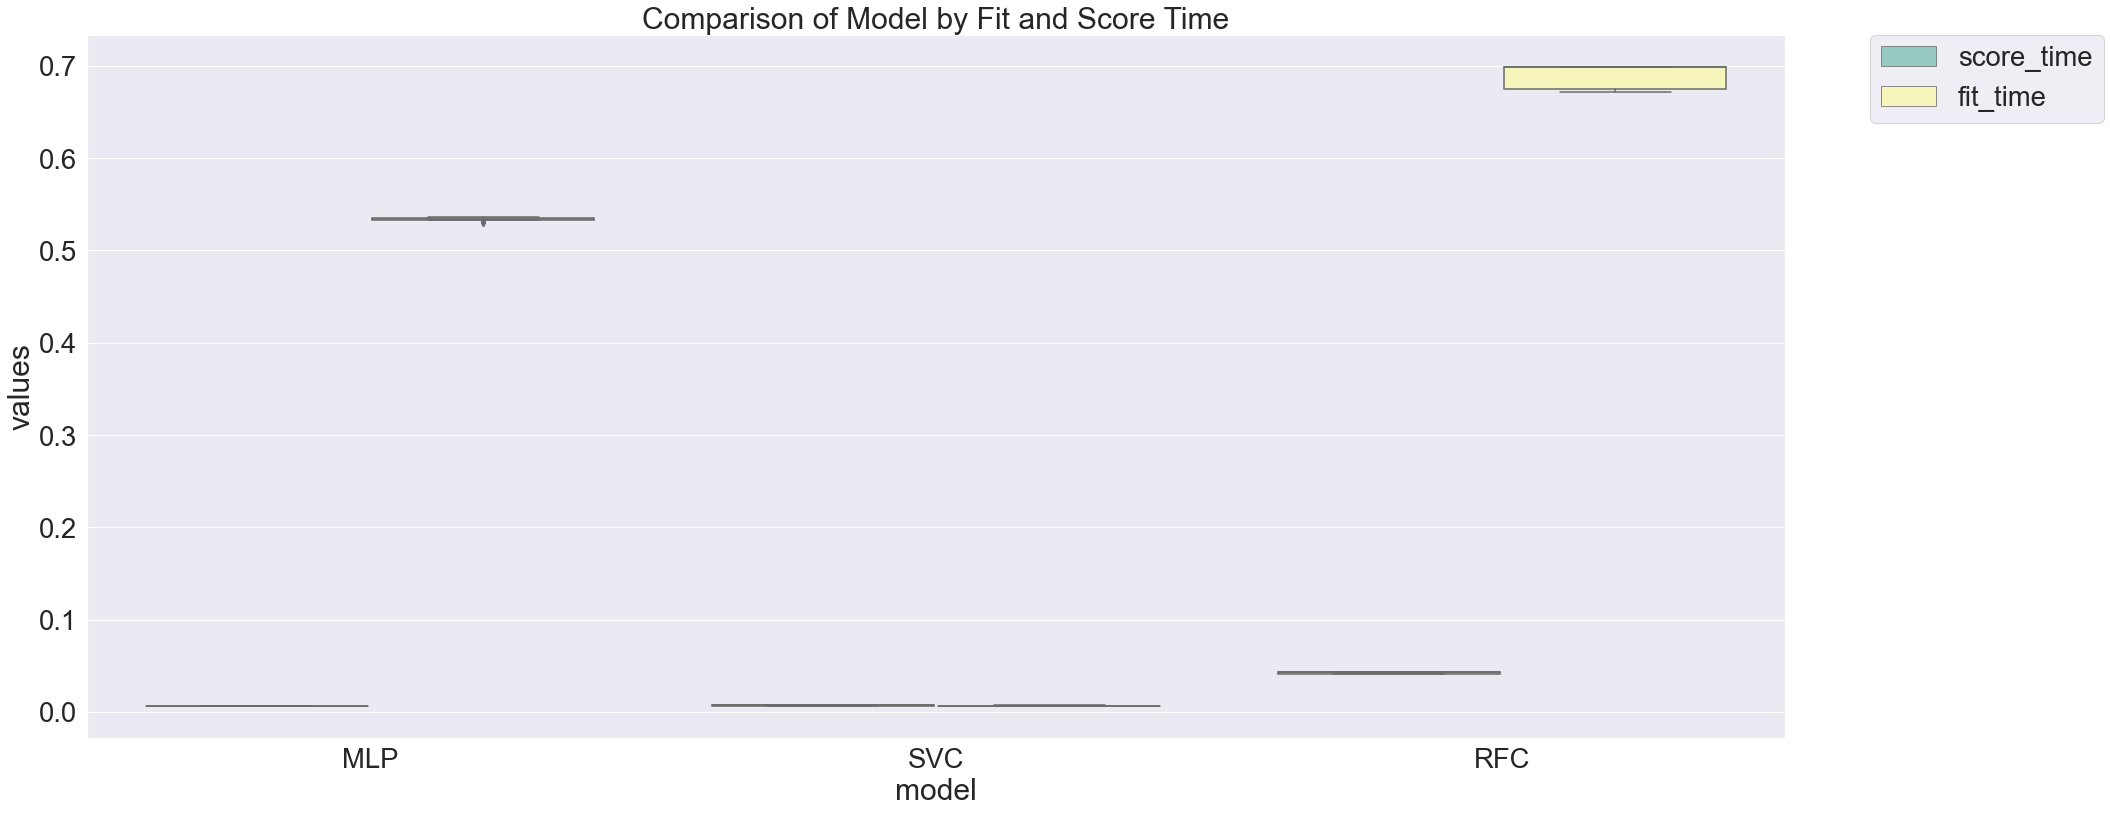

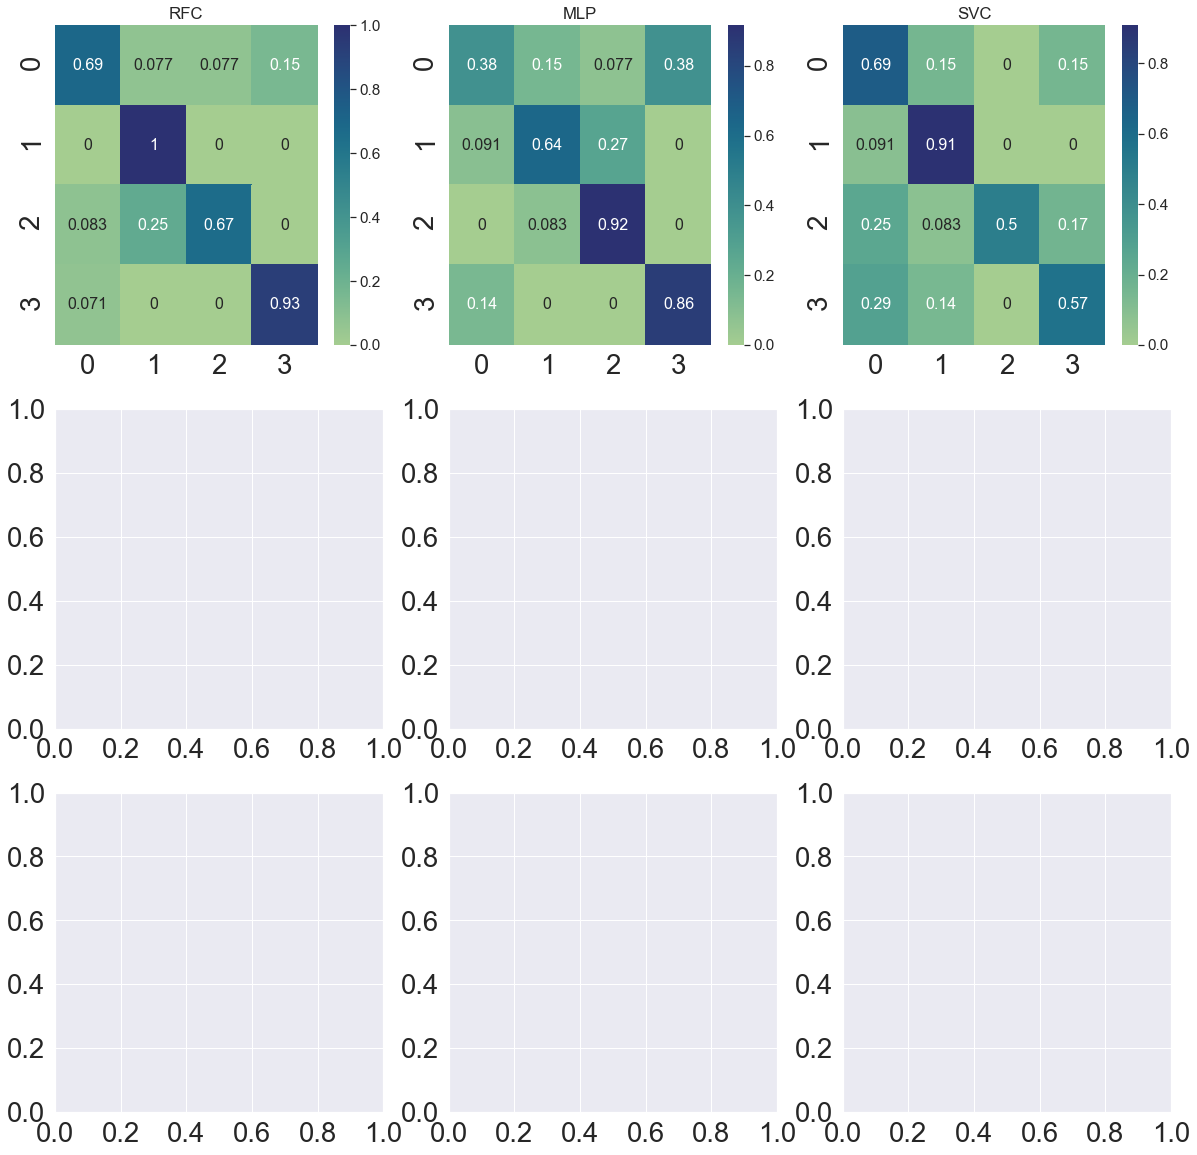

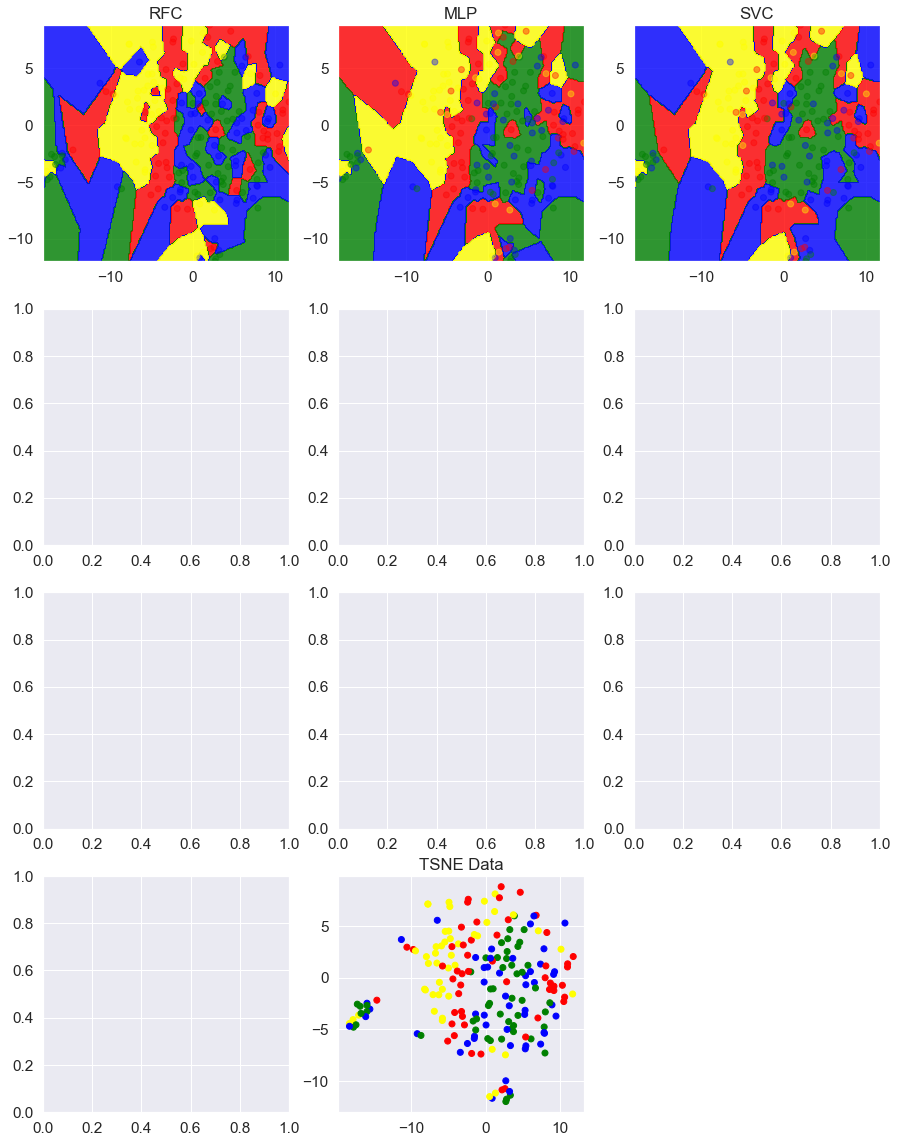

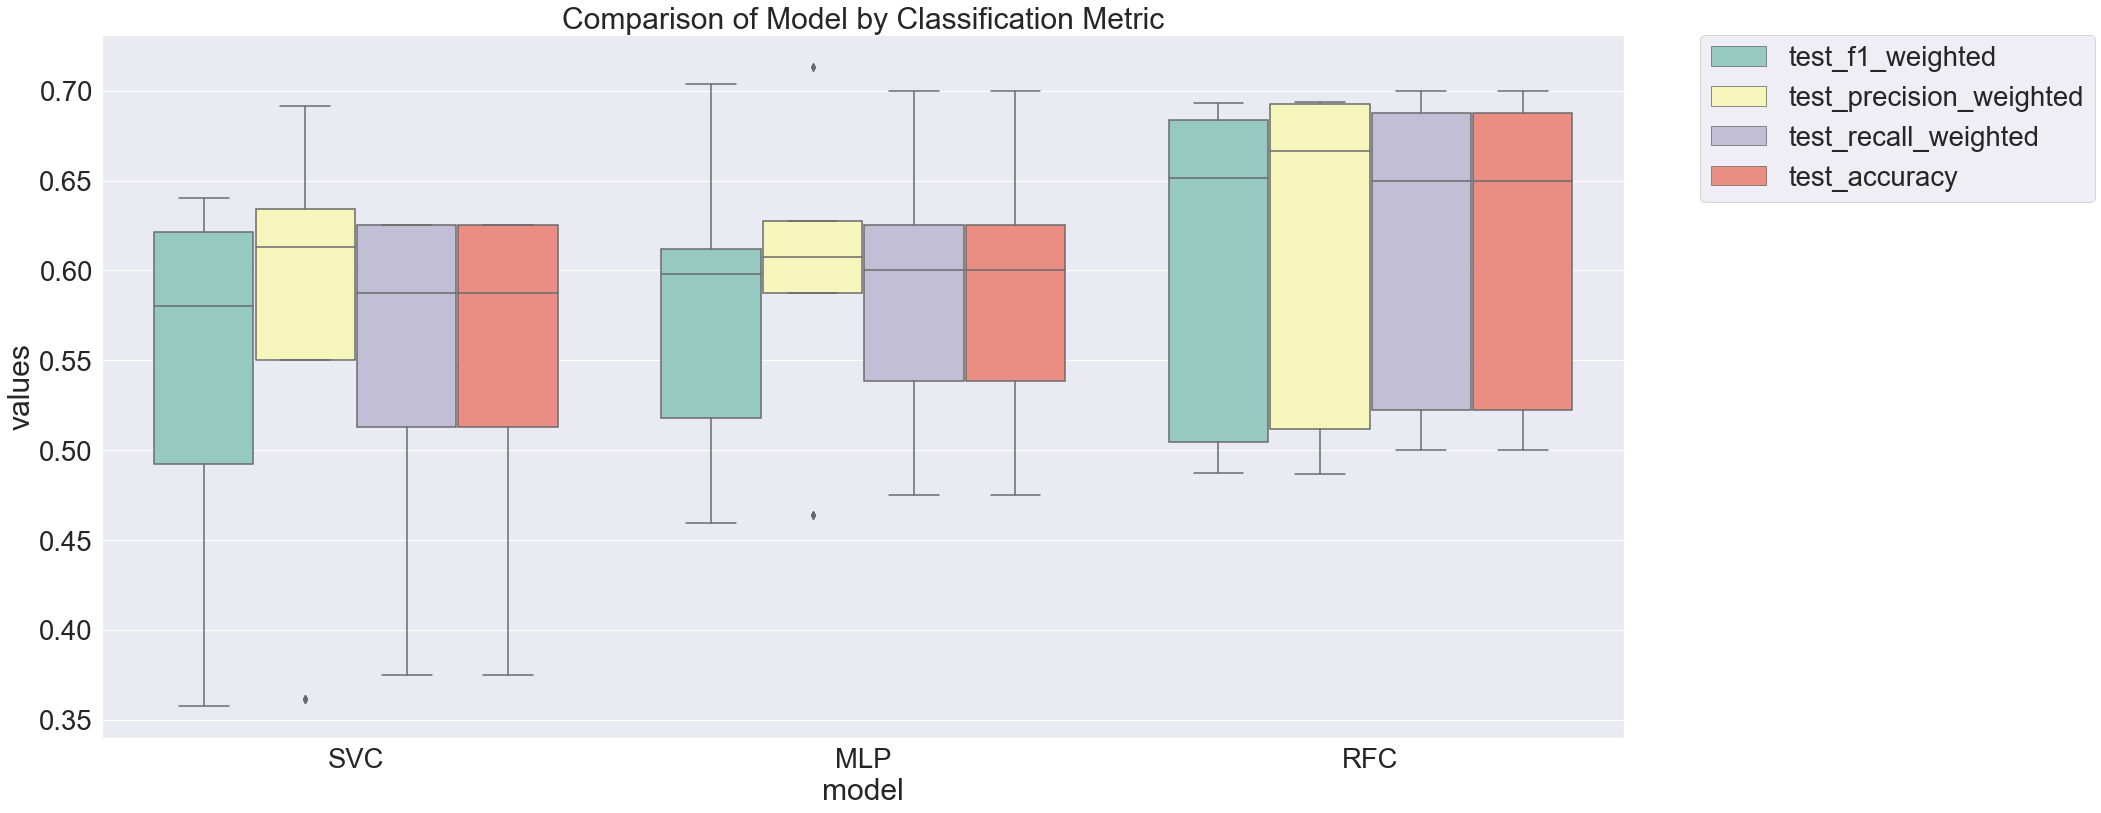

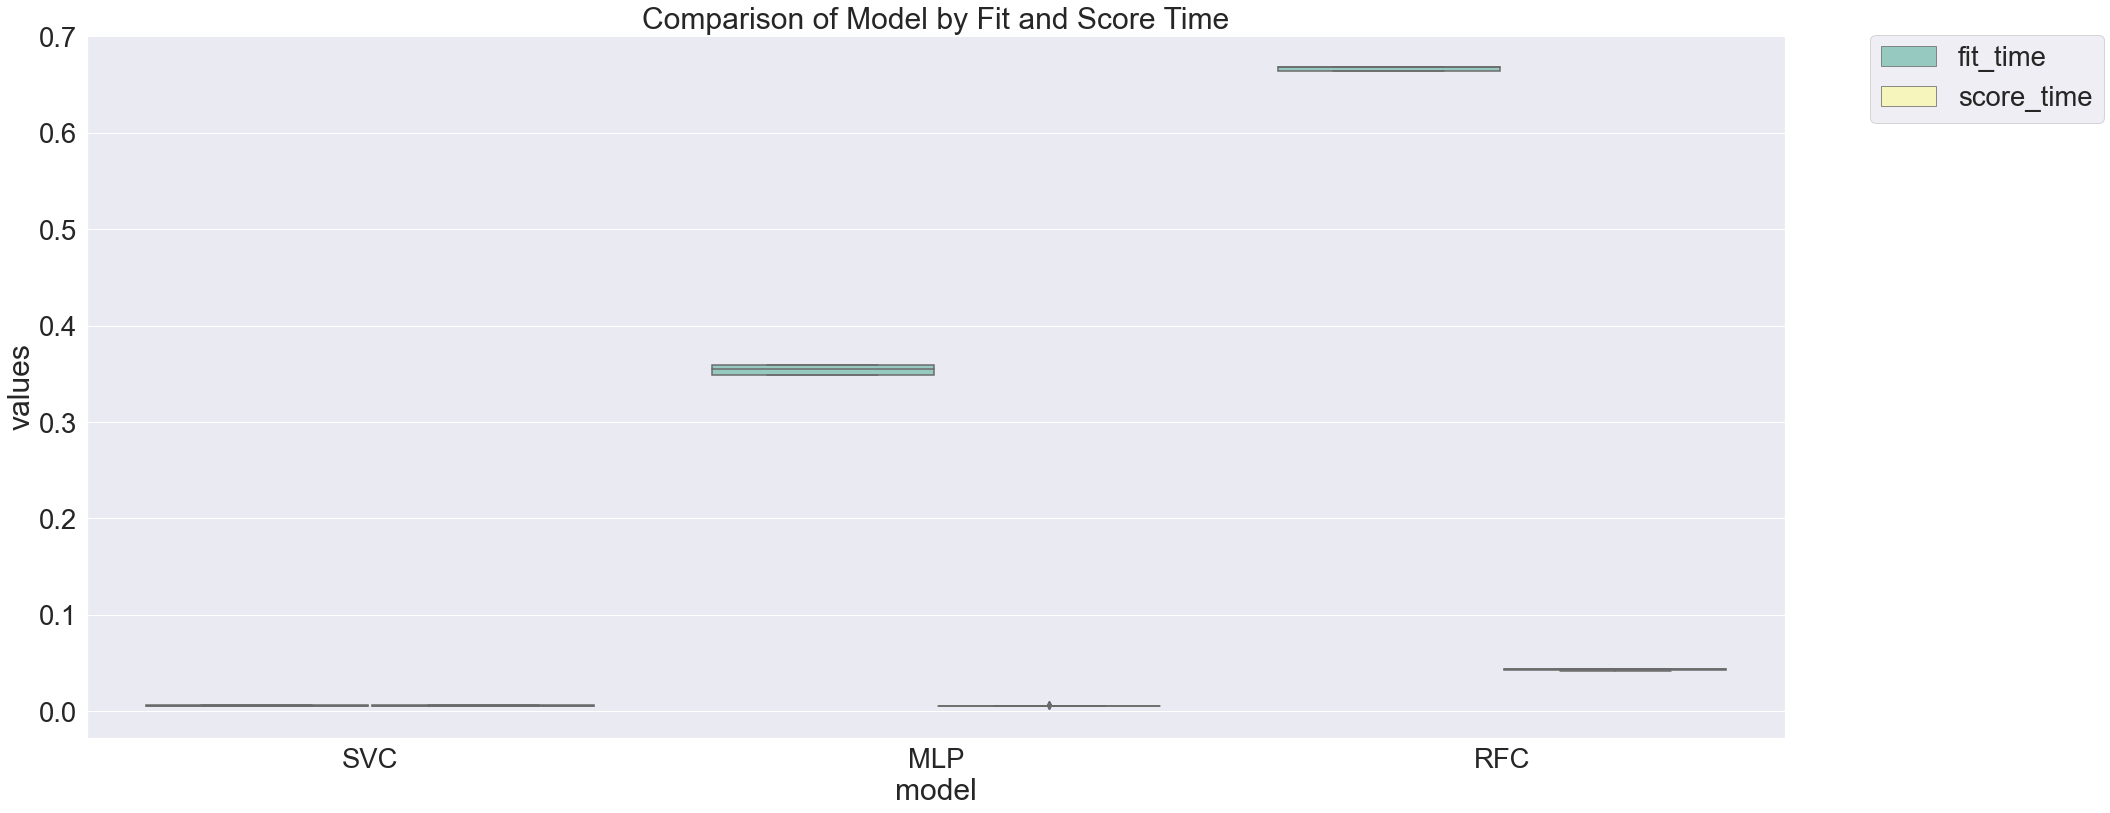

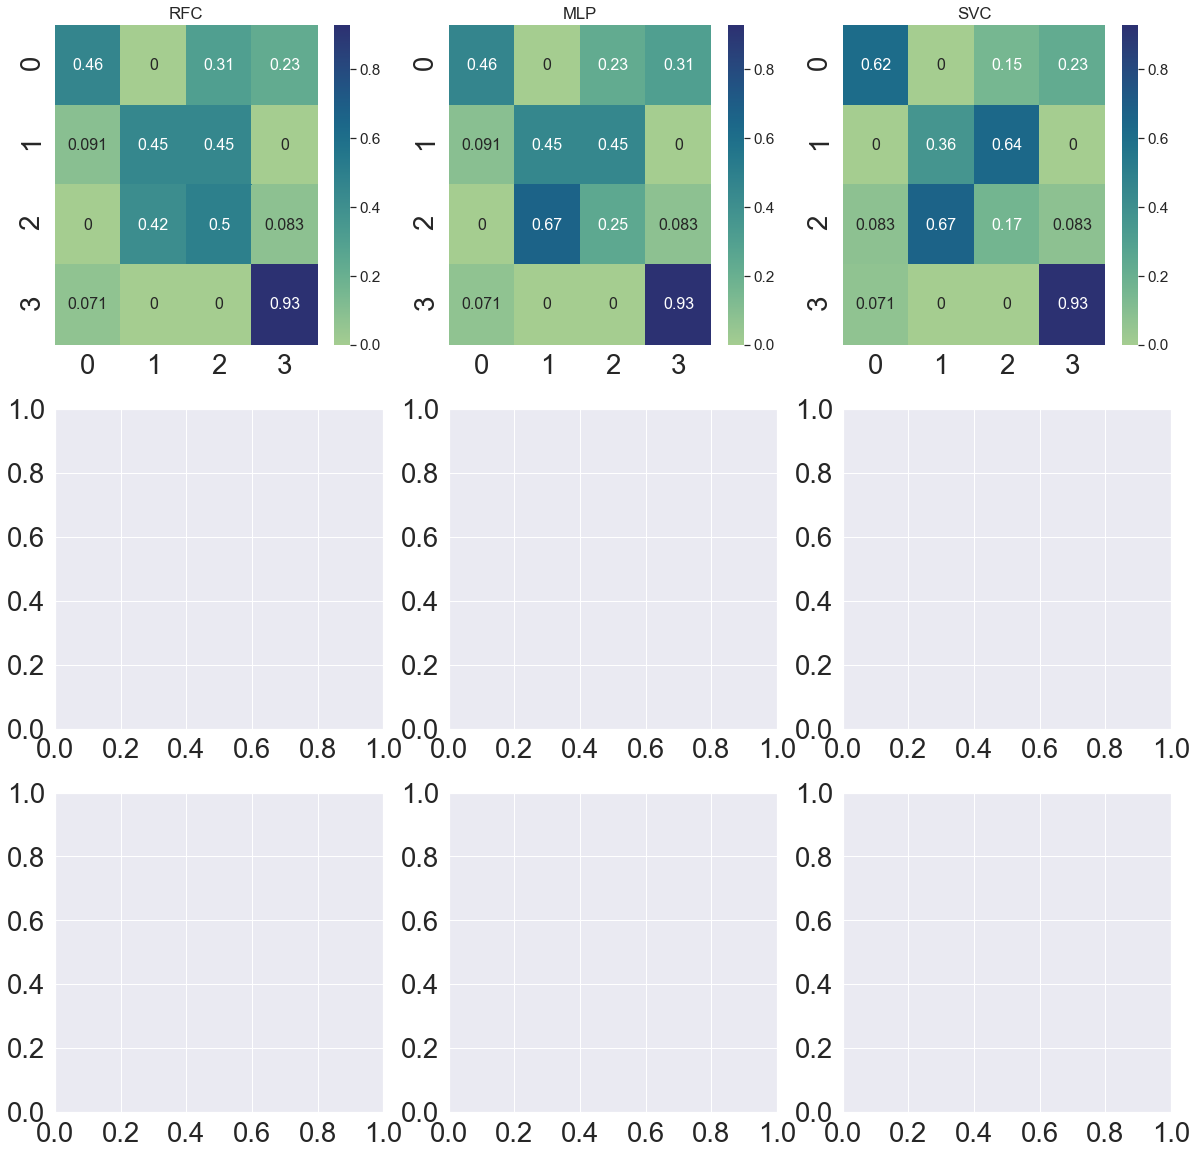

In [5]:
import performance_metrics
#best for binary with eye?

models = [("RFC",RandomForestClassifier(max_depth=100, min_samples_leaf=2, n_estimators=400)),("MLP",MLPClassifier(activation='logistic', batch_size=20, learning_rate='adaptive',
              max_iter=100)),("SVC",SVC())]
results = {"completedatatuned": "./processed_data/completeData.csv","ecggsrtuned": "./processed_data/completeDatanoeye.csv"}
performance_metrics.main(results, models)

c:\users\tomje\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\tomje\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\tomje\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\tomje\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

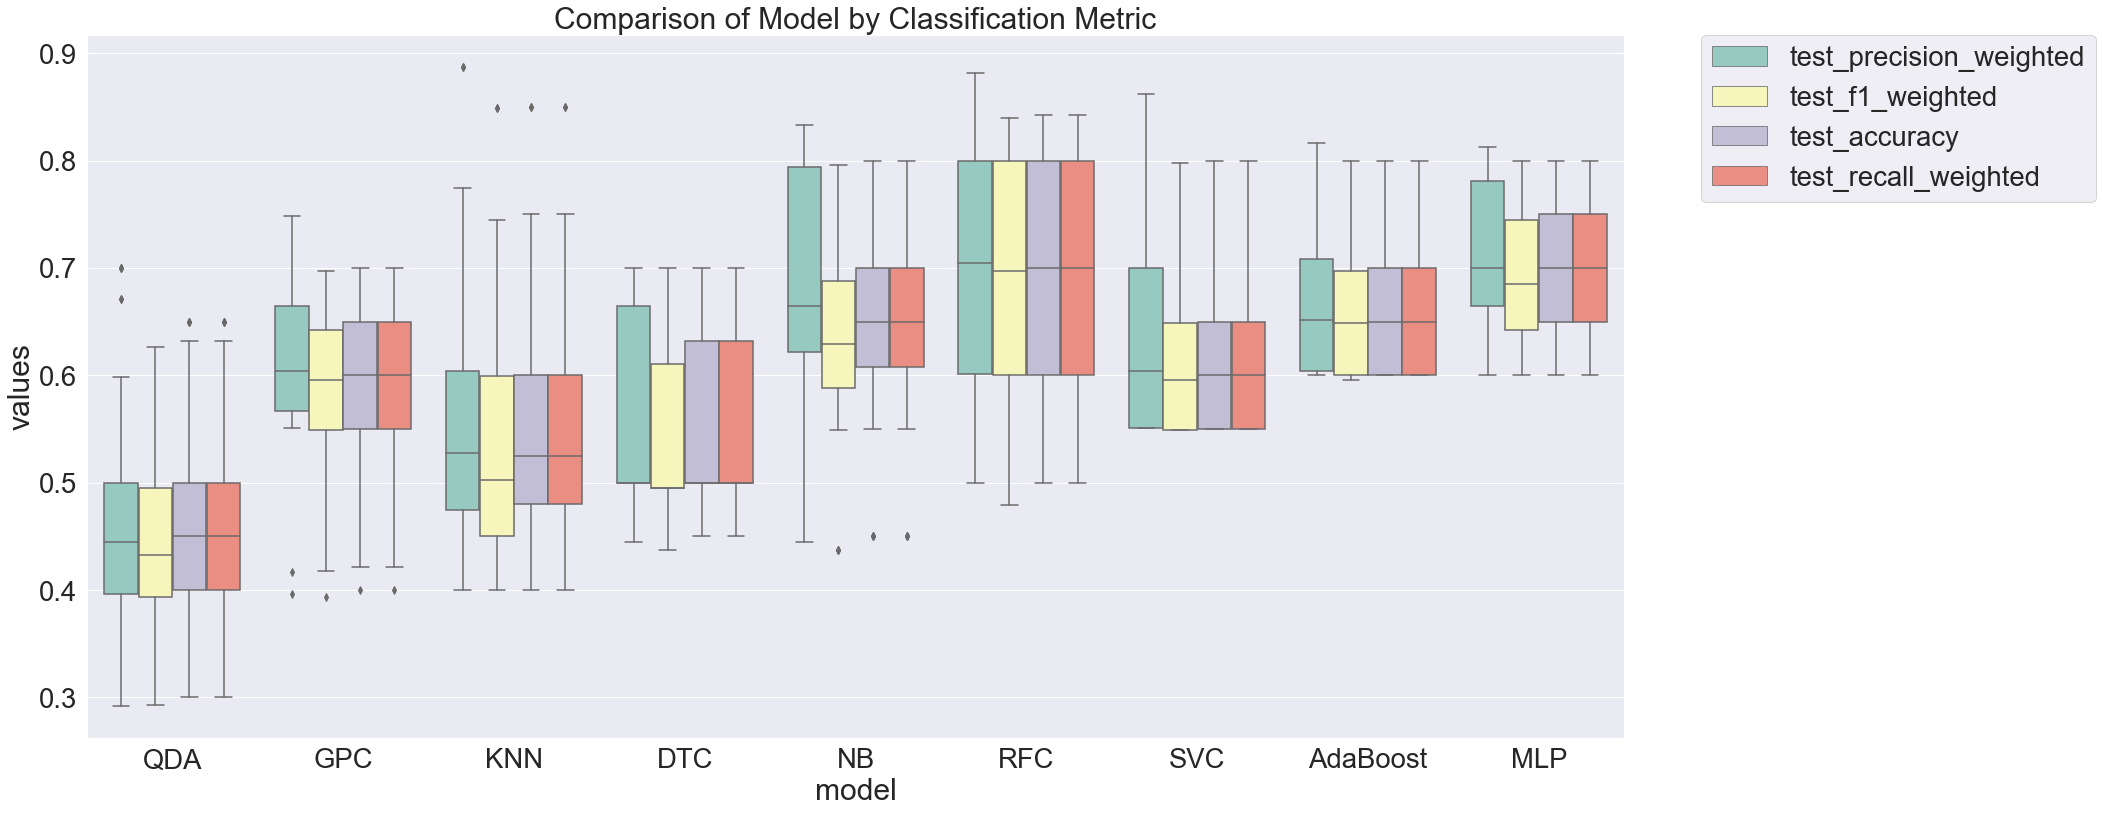

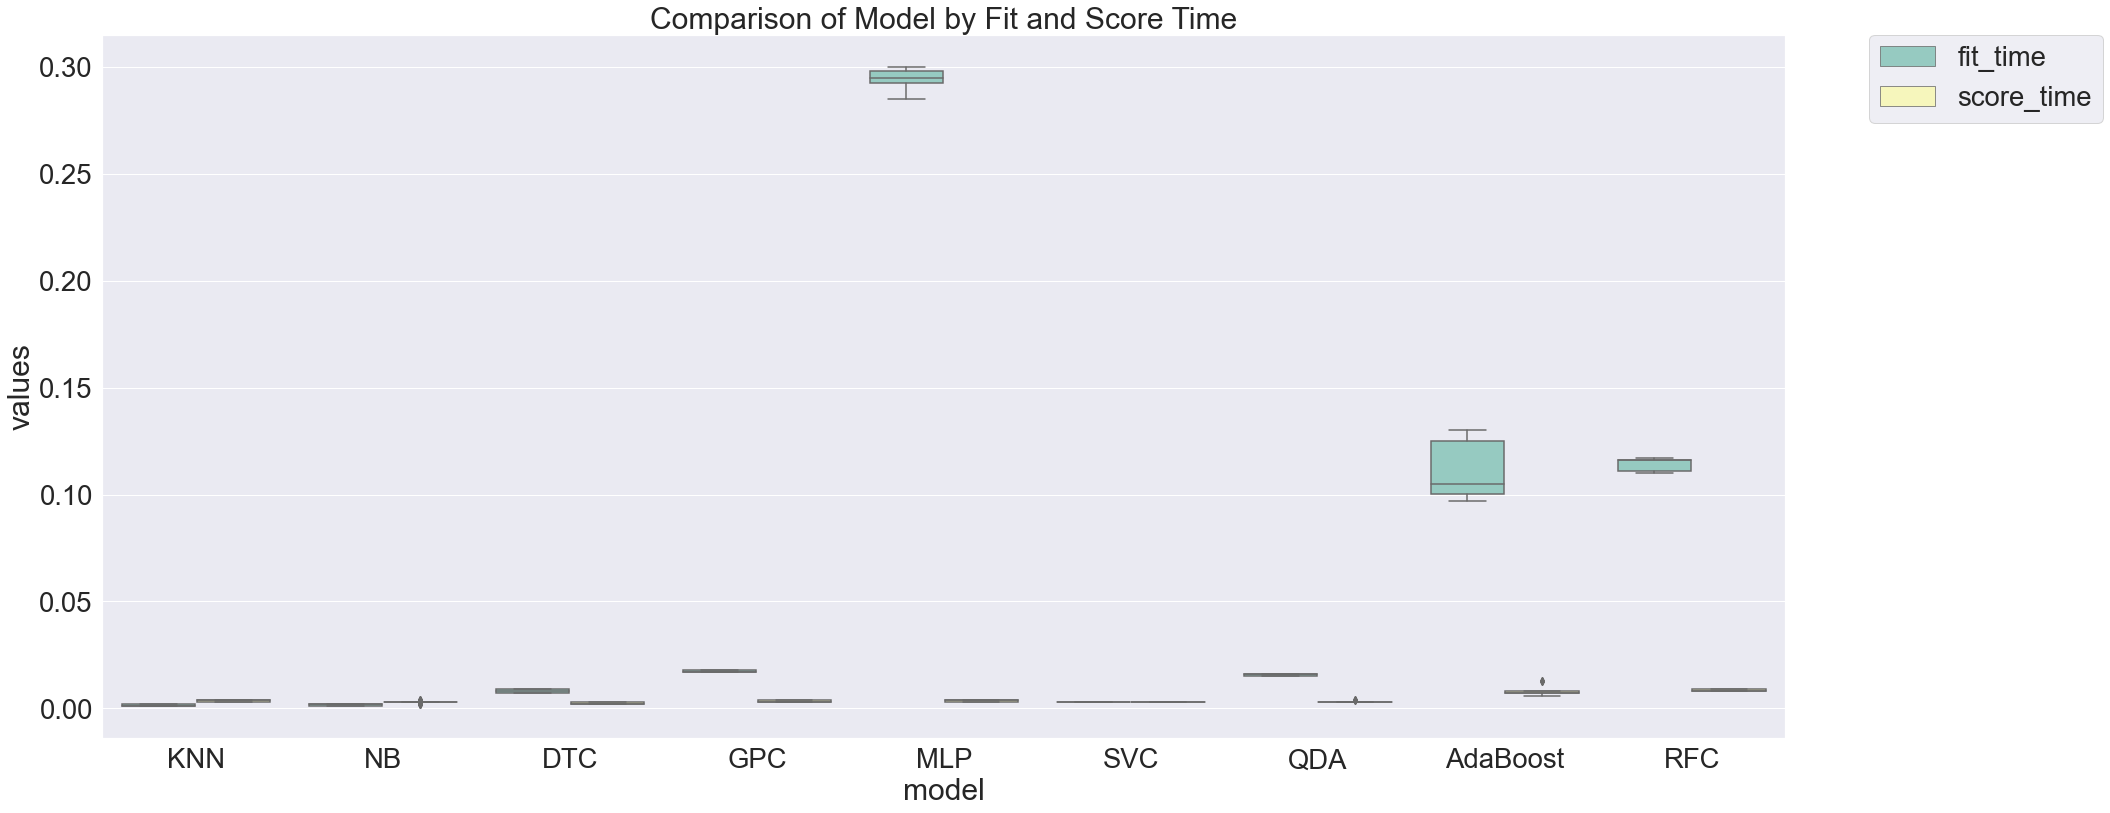

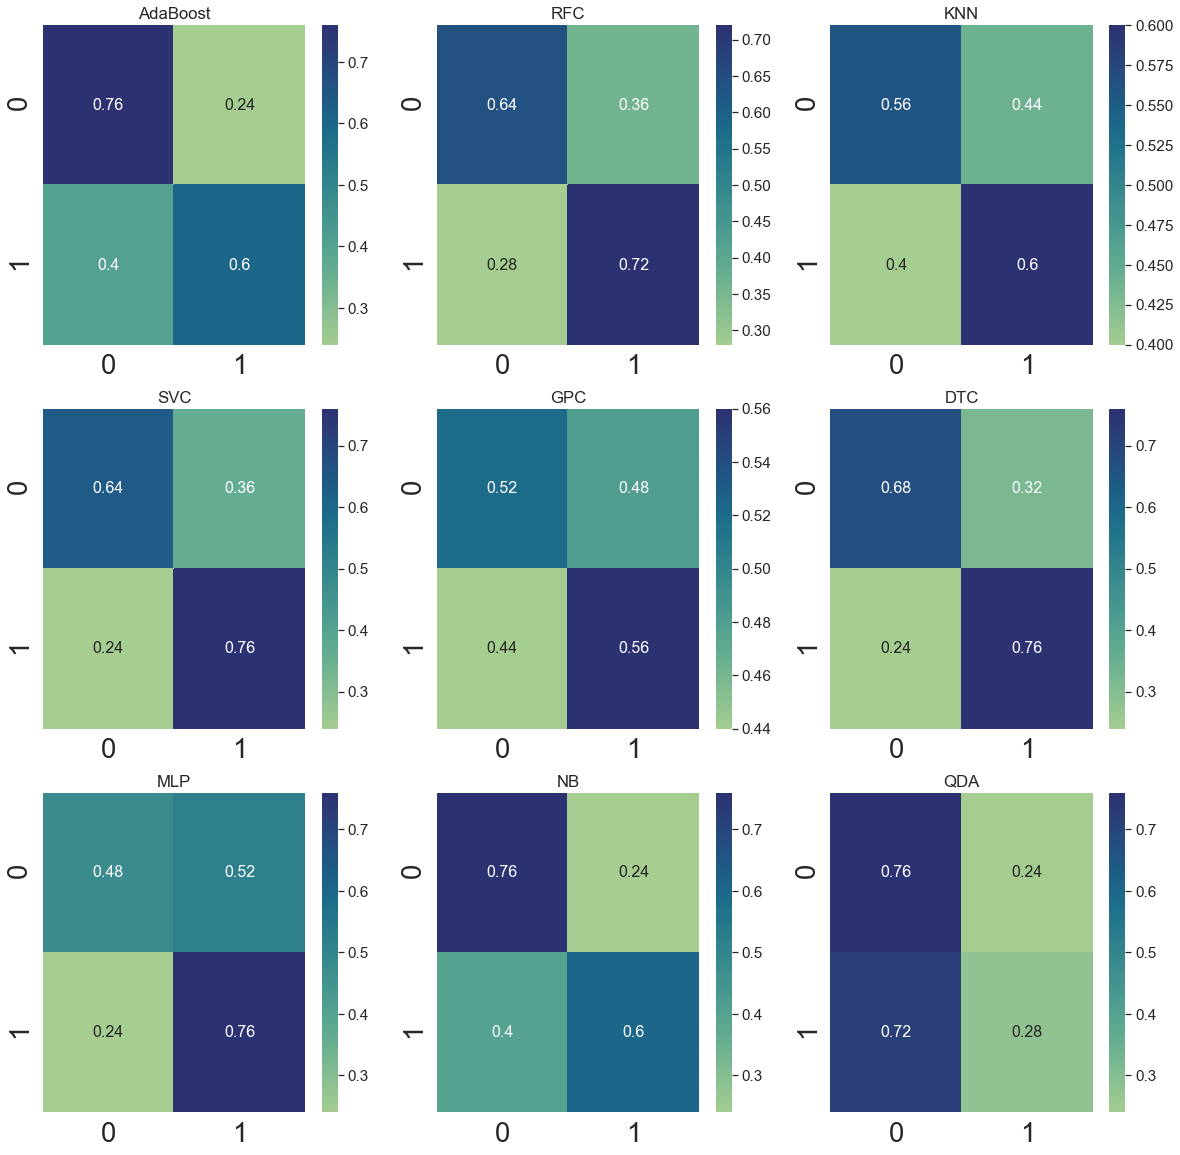

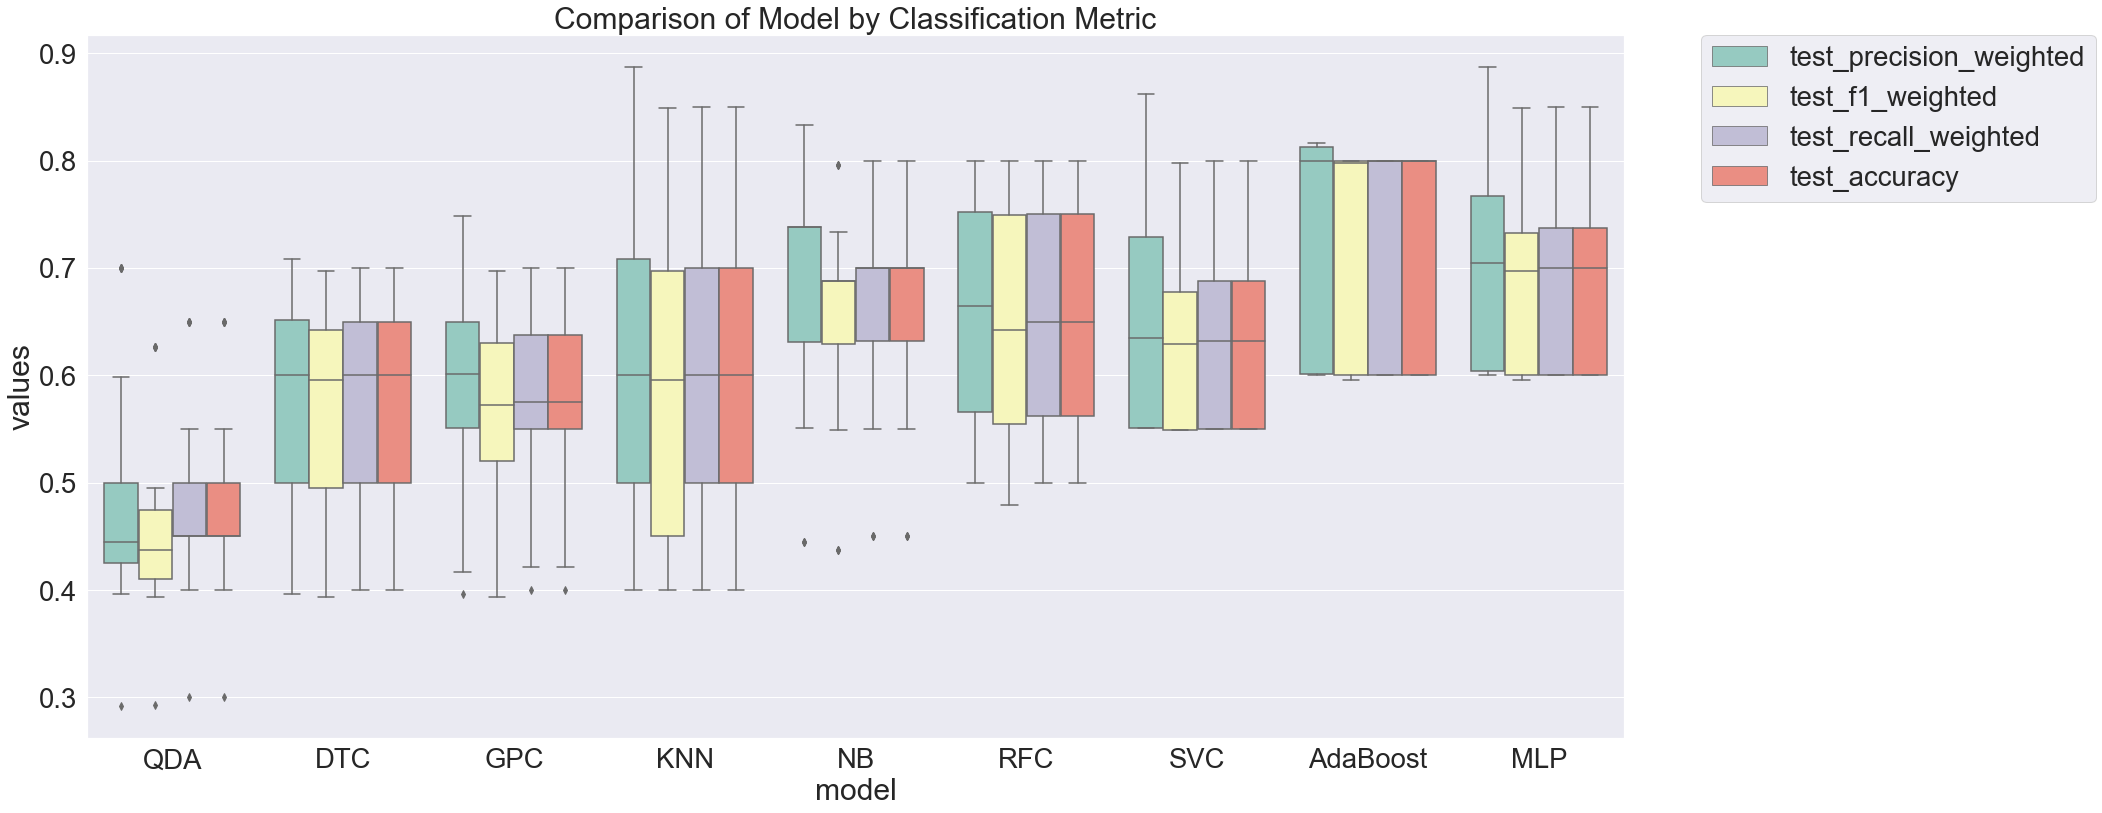

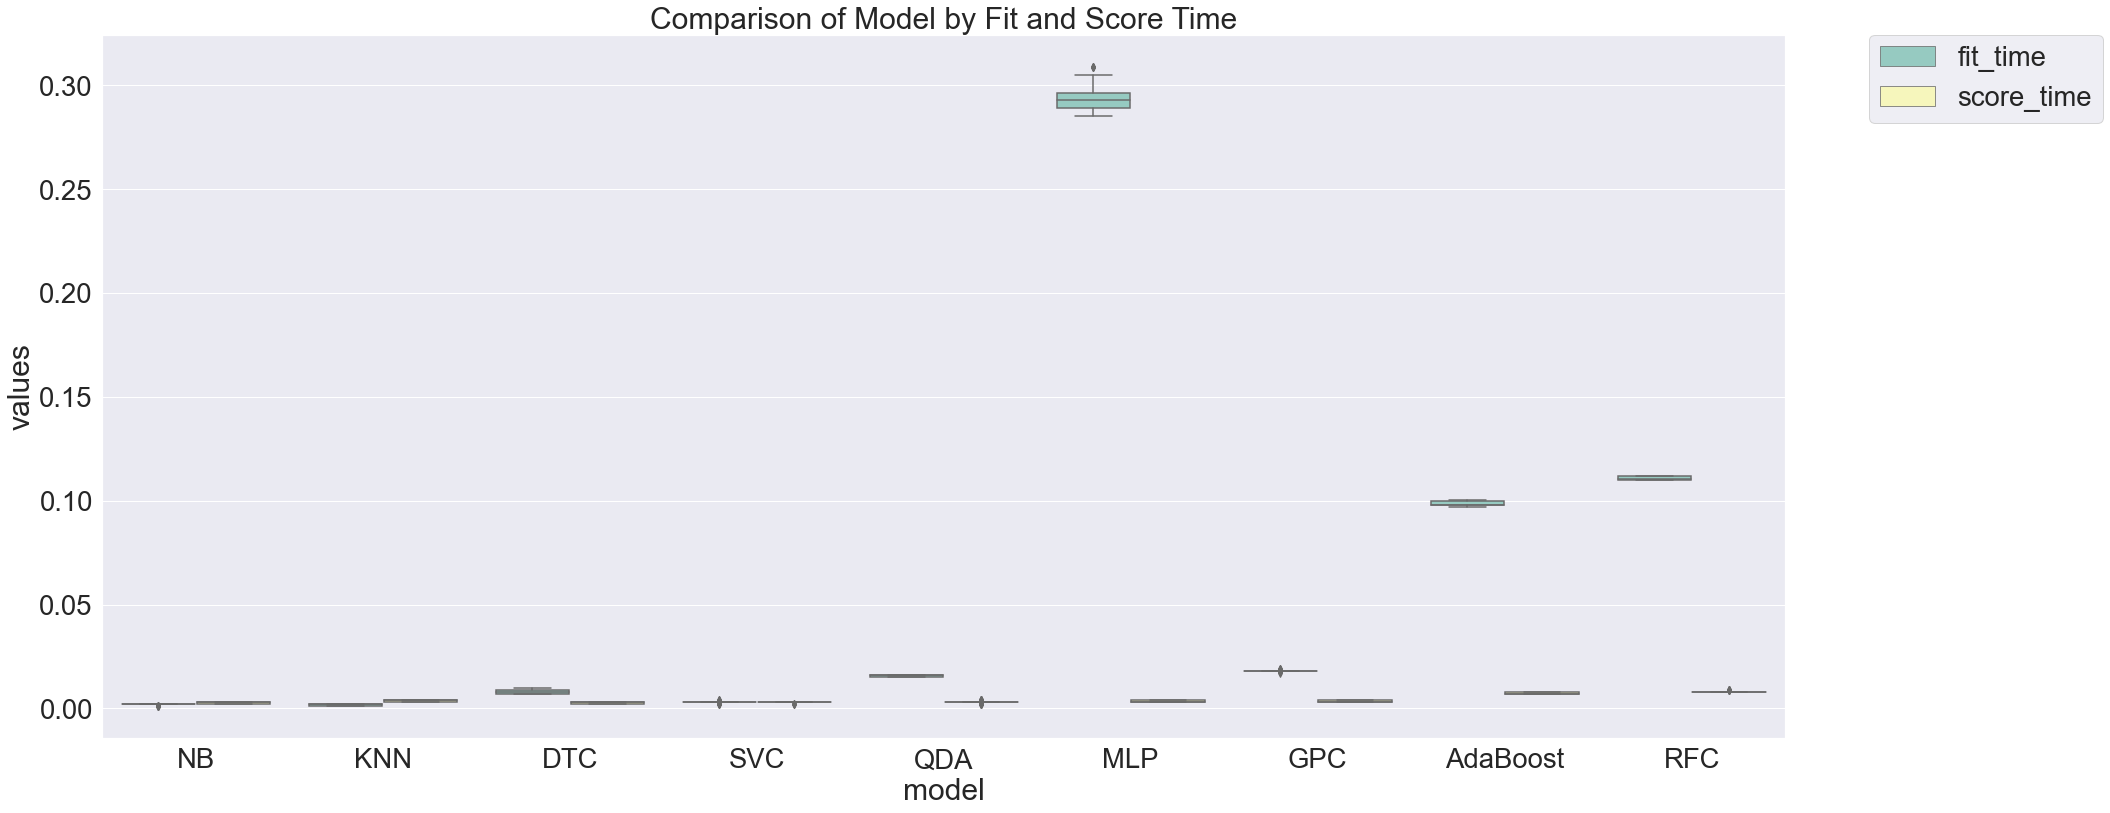

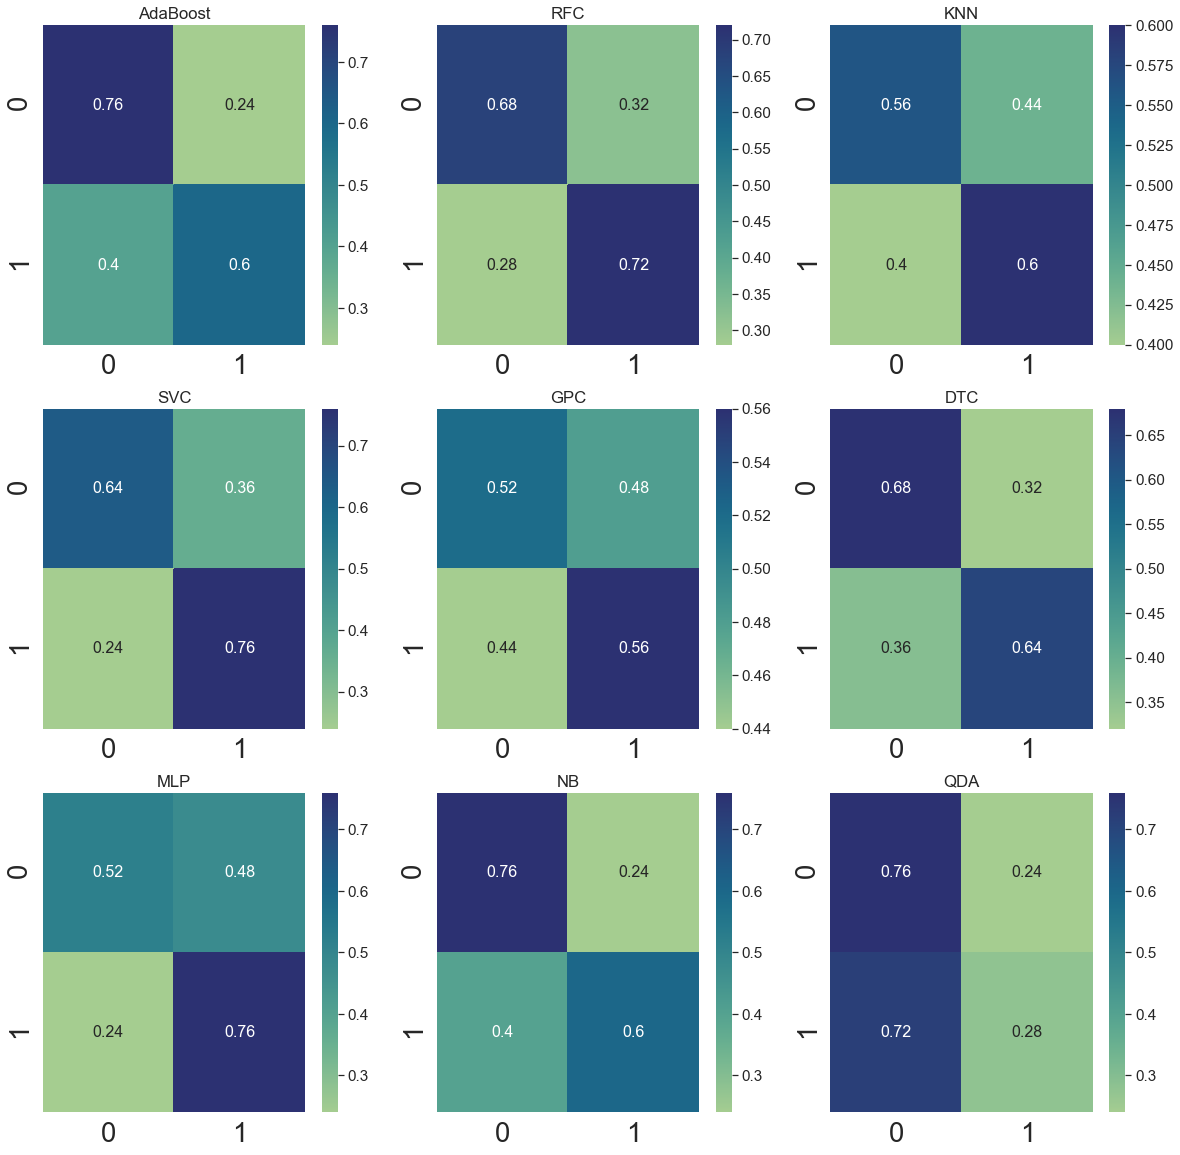

In [2]:
import performance_metrics
#best for binary with eye?


results = {"databinarynoeyearous": "./processed_data/completeDatabinaryarous.csv","databinaryarous": "./processed_data/completeDatabinaryarous.csv"}
performance_metrics.main(results)
